# JVJ65 Analysis
****

A **quality-comparative analysis of NGS data** between different Illumina pipelines and parameters. 
Motivation: The Windows 10 update on our sequencers has led to the installation of the new Illumina software. The aim of this analysis are: 

   - I) Check if the Myeloid-panels results obtained with the previous (win7) and the new (win10) softwares provide similar results.  
    
   - II) Compare the win10 outputs between them. The new software allows the user to turn off/on the parameters *Indel Realignment* and *Read Stitching*. We have run and compared the four different combinations
    
   - III) Sensitivity and specificity study of the win10-variants using as control the win7-variants



### Table of Contents


* [Load data and minimal readjustments for comparison ](#0)


* [A general comparison - Venn diagrams  ](#0.1)


* [Win7 vs. No Stitch - No Realignment](#1)
    * [Total variants](#1.1)
    * [Common variants](#1.2)
        * [Common variants (Differences)](#1.2.1)
        

* [Win7 vs.  Stitch - No Realignment](#2)
    * [Total variants](#2.1)
    * [Common variants](#2.2)
        * [Common variants (Differences)](#2.2.1)


* [Win7 vs.  Stitch -  Realignment](#3)
    * [Total variants](#3.1)
    * [Common variants](#3.2)
        * [Common variants (Differences)](#3.2.1)


* [Win7 vs.  No Stitch -  Realignment](#4)
    * [Total variants](#4.1)
    * [Common variants](#4.2)
        * [Common variants (Differences)](#4.2.1)


* [How many and how are the variants called by win7 and not calledby win10 and vice versa](#5)


* [No Stitch - Realignment vs. Stitch - Realignment](#6)


* [Diagnostic test: Sensitivity and Specificity ](#7)


A function to hide specific input cells to make the notebook easier to read.

In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()
# Copied from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook

The libraries:

In [3]:
import sys
import pandas as pd
import os
import seaborn as sns, numpy as np
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from matplotlib_venn import venn2
hide_toggle()

Some functions to manipulate the input data. 

We need to do some calculations to get the variant frequency and the coverage. 

Apart from this, Win10 output presents different ID variants. To allow comparison between the win7 and win10 variants, win10-variant ID needs to be adapted.

In [4]:
def generate_VF_Coverage(df):
    """ Using find_read_depth and get_VF 
        create variant coverage and variant frecuency
    """
    df["Coverage"] = pd.to_numeric(df["AD"].apply(find_read_depth))
    df["VF"] = pd.to_numeric(df.apply(get_VF,axis=1))
    return df

def find_read_depth(AD):
    """
    Fount out that a minimal number of 0/0 variants 
    (e.g.: 572 chrX 15808795 . T . 100 PASS DP=790;RefMinor;GMAF=T|0.002649;phyloP=-2.424;... GT:GQ:AD:DP:VF:NL:SB:NC 0/0:18:788:790:0.0025:24:-100.0000:0.1023)
    Allelic Depth column doesnt present the number of read for alt
    This return a error when AD column is splited in two to do some calculation to get the Coverage and VF
    This function solves this issue
    """
    try:
        return int(AD.split(",")[0]) + int(AD.split(",")[1])
    except IndexError:
        return int(AD.split(",")[0])
    
def get_VF(variant: pd.Series) -> float:
    """Calculates variant allele frequency from VCF entry
    If IndexError or ZeroDivisionError is arised, except the error and add a 0
    """
    try:
        result = float(variant["AD"].split(",")[1]) / variant["Coverage"]
        assert isinstance(result, float), "ERROR: Unexpected value"
        return result
    except (IndexError,ZeroDivisionError):
        return 0

def modify_win10_data(df_input):
    """
    The win10 ID  are slighly different compared with win7 ID.
    To match both, we need first to change a bit win10 ID variants.
    This function carry out these modifications.
    """
    df_input["Wnumber"] = df_input["Sample_ID"].apply(lambda x: x.split("_")[0])
    df_input["position"] = df_input["Sample_ID"].apply(lambda x: x.split("bam")[1])
    df_input = df_input.iloc[: , 1:]
    df_input["Sample_ID"] = df_input["Wnumber"] + df_input["position"]
    df_input = df_input[["Sample_ID","QUAL","FILTER","GT","AD","SB","VF","Coverage"]]
    # Columns need to be rename to be able to distingues them:
    df_output = df_input.rename(columns={"Sample_ID":"10Sample_ID","QUAL":"10QUAL","FILTER":"10FILTER","GT":"10GT",
                              "AD":"10AD","SB":"10SB","VF":"10VF","Coverage":"10Coverage"})
    
    return df_output
    
hide_toggle()

## Load data and minimal readjustments for comparison <a class="anchor" id="0"></a>
****

In [6]:
print("The data:")

# Win7:
win7 = pd.read_csv("/Users/monkiky/Desktop/Win7-10_comparison/JVJ65/Data_output/win7_JVJ65_output/JVJ65_Win7.csv", )
win7 = win7.iloc[: , 1:]
win7 = generate_VF_Coverage(win7)
print("- Win7:")
display(win7[win7["Sample_ID"].str.endswith('chr1:36933569A>G')].iloc[[1,3,5]].style.hide_index())
print(win7.shape[0], "rows",win7.shape[1], "columns")
print("\n")


# Win10:
# No Stitch - No Realignment
NoStitch_NoReal = pd.read_csv("//Users/monkiky/Desktop/Win7-10_comparison/JVJ65/Data_output/win10_JVJ65_output/JVJ65_Win10_NoStith_NoReal.csv", )
NoStitch_NoReal = NoStitch_NoReal.iloc[: , 1:]
NoStitch_NoReal = generate_VF_Coverage(NoStitch_NoReal)
print("- No Stitch No Realignment:")
display(NoStitch_NoReal[NoStitch_NoReal["Sample_ID"].str.endswith('chr1:36933569A>G')].iloc[[0,1,2]].style.hide_index())
print(NoStitch_NoReal.shape[0], "rows",NoStitch_NoReal.shape[1], "columns")
print("\n")


# Stitch - Realignment
Stitch_Real = pd.read_csv("/Users/monkiky/Desktop/Win7-10_comparison/JVJ65/Data_output/win10_JVJ65_output/JVJ65_Win10_Stitch_Real.csv", )
Stitch_Real = Stitch_Real.iloc[: , 1:]
Stitch_Real = generate_VF_Coverage(Stitch_Real)
print("- Stitch Realignment:")
display(NoStitch_NoReal[NoStitch_NoReal["Sample_ID"].str.endswith('chr1:36933569A>G')].iloc[[0,1,2]].style.hide_index())
print(Stitch_Real.shape[0], "rows",Stitch_Real.shape[1], "columns")
print("\n")


# No Stitch - Realignment
NoStitch_Real = pd.read_csv("/Users/monkiky/Desktop/Win7-10_comparison/JVJ65/Data_output/win10_JVJ65_output/JVJ65_Win10_NoStitch_Real.csv", )
NoStitch_Real = NoStitch_Real.iloc[: , 1:]
NoStitch_Real = generate_VF_Coverage(NoStitch_Real)
print("- No Stitch Realignment:")
display(NoStitch_NoReal[NoStitch_NoReal["Sample_ID"].str.endswith('chr1:36933569A>G')].iloc[[0,1,2]].style.hide_index())
print(NoStitch_Real.shape[0], "rows",NoStitch_Real.shape[1], "columns")
print("\n")

# Stitch - No Realignment
Stitch_NoReal = pd.read_csv("/Users/monkiky/Desktop/Win7-10_comparison/JVJ65/Data_output/win10_JVJ65_output/JVJ65_Win10_Stitch_NoReal.csv", )
Stitch_NoReal = Stitch_NoReal.iloc[: , 1:]
Stitch_NoReal = generate_VF_Coverage(Stitch_NoReal)
print("- Stitch No Realignment:")
display(NoStitch_NoReal[NoStitch_NoReal["Sample_ID"].str.endswith('chr1:36933569A>G')].iloc[[0,1,2]].style.hide_index())
print(Stitch_NoReal.shape[0], "rows",Stitch_NoReal.shape[1], "columns")

hide_toggle()


The data:
- Win7:


Sample_ID,QUAL,FILTER,GT,AD,SB,Coverage,VF
W2114447chr1:36933569A>G,100.000000,SB,0/1,"1085,46",-0.079300,1131,0.040672
W2113856chr1:36933569A>G,100.000000,SB,0/1,"1424,71",-0.007100,1495,0.047492
W2114554chr1:36933569A>G,100.000000,SB,0/1,"1405,51",-0.008100,1456,0.035027


4809 rows 8 columns


- No Stitch No Realignment:


Sample_ID,QUAL,FILTER,GT,AD,SB,Coverage,VF
W2114447_S13.bamchr1:36933569A>G,22,PASS,0/1,"553,11",-5.698700,564,0.019504
W2113856_S16.bamchr1:36933569A>G,14,SB;q20,0/1,"803,10",-2.974000,813,0.012300
W2114554_S14.bamchr1:36933569A>G,21,PASS,0/1,"725,11",-10.088900,736,0.014946


13872 rows 8 columns


- Stitch Realignment:


Sample_ID,QUAL,FILTER,GT,AD,SB,Coverage,VF
W2114447_S13.bamchr1:36933569A>G,22,PASS,0/1,"553,11",-5.698700,564,0.019504
W2113856_S16.bamchr1:36933569A>G,14,SB;q20,0/1,"803,10",-2.974000,813,0.012300
W2114554_S14.bamchr1:36933569A>G,21,PASS,0/1,"725,11",-10.088900,736,0.014946


13628 rows 8 columns


- No Stitch Realignment:


Sample_ID,QUAL,FILTER,GT,AD,SB,Coverage,VF
W2114447_S13.bamchr1:36933569A>G,22,PASS,0/1,"553,11",-5.698700,564,0.019504
W2113856_S16.bamchr1:36933569A>G,14,SB;q20,0/1,"803,10",-2.974000,813,0.012300
W2114554_S14.bamchr1:36933569A>G,21,PASS,0/1,"725,11",-10.088900,736,0.014946


13816 rows 8 columns


- Stitch No Realignment:


Sample_ID,QUAL,FILTER,GT,AD,SB,Coverage,VF
W2114447_S13.bamchr1:36933569A>G,22,PASS,0/1,"553,11",-5.698700,564,0.019504
W2113856_S16.bamchr1:36933569A>G,14,SB;q20,0/1,"803,10",-2.974000,813,0.012300
W2114554_S14.bamchr1:36933569A>G,21,PASS,0/1,"725,11",-10.088900,736,0.014946


13655 rows 8 columns


Some comments:

    1) The same three variants are shown in the previous visualization. It can be seen how the same variants present different values. E.g.: the first one (W2114447chr1:36933569A>G) doesn´t pass the filter SB in the win7 dataset but it does pass all filters in the win10 datasets.
    
    2) It seems that win10 variants are very similar. We will explore this in detail below.
    
    3) Comparing win7 variants with win10 variants, we can see what has been mentioned above. The name is slightly different. 

We can delete the extra strings in the win10-variant ID using the function modify_win10_data() previously created.

In [7]:
NoStitch_NoRealm = modify_win10_data(NoStitch_NoReal)
Stitch_NoRealm = modify_win10_data(Stitch_NoReal)
Stitch_Realm = modify_win10_data(Stitch_Real)
NoStitch_Realm = modify_win10_data(NoStitch_Real)
hide_toggle()


## Venn diagrams for a general comparison  <a class="anchor" id="0.1"></a>


We can use Venn diagrams to compare the number of variants that are in common between the five datasets.

<Figure size 4800x3200 with 0 Axes>

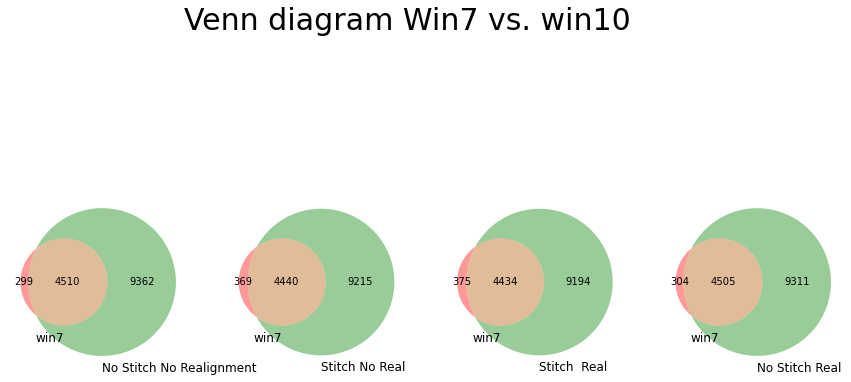

In [8]:
plt.figure(dpi=800)
plt.figure(figsize = (15,8))

plt.suptitle('Venn diagram Win7 vs. win10 ', fontsize=30)


plt.subplot(1,4,1)
v = venn2([set(win7['Sample_ID'].to_list()), 
       set(NoStitch_NoRealm['10Sample_ID'].to_list()),
      ],
       set_labels=('win7', 'No Stitch No Realignment', )
     )


plt.subplot(1,4,2)


venn2([set(win7['Sample_ID'].to_list()), 
       set(Stitch_NoRealm['10Sample_ID'].to_list()),
      ],
       set_labels=('win7', "Stitch No Real")
     )

plt.subplot(1,4,3)

venn2([set(win7['Sample_ID'].to_list()), 
       set(Stitch_Realm['10Sample_ID'].to_list()),
      ],
       set_labels=('win7', "Stitch  Real")
     )

plt.subplot(1,4,4)

venn2([set(win7['Sample_ID'].to_list()), 
       set(NoStitch_Realm['10Sample_ID'].to_list()),
      ],
       set_labels=('win7', "No Stitch Real")
     )
hide_toggle()


Win7 variants that don´t match with the win10 variants are in red. Common variants in orange. Win10 variants that don´t match with the win7 variants in green.

In general, more than 97% of all win7 variants are called in the four win10 versions. *No Stitch No Realignment* is the most similar dataset with win7 output.

The win10 datasets contain approximately the double than the win7 dataset. According to the numbers, it seems that there are no significant differences between the 4 win10 versions. We are going to do more detailed analysis to confirm this. We are going to compare each win10 dataset with the win7 data.

# Win7 vs. No Stitch - No Realignment <a class="anchor" id="1"></a>


****
### Total variants <a class="anchor" id="1.1"></a>


To create boxplots,  datasets need to be concatenated. To be able to distinguish them, I have added an indicator (an additional column with their names).

In [9]:
win7.insert(0, 'Indicator', 'win7')
NoStitch_NoReal.insert(0, 'Indicator', 'NoStitch_NoReal')
frames = [win7, NoStitch_NoReal]
win7_NoStitch_NoReal = pd.concat(frames)
display(win7_NoStitch_NoReal)
hide_toggle()

,Indicator,Sample_ID,QUAL,FILTER,GT,AD,SB,Coverage,VF,Wnumber,position
0,win7,W2114579chr1:36933569A>G,100.0,SB,0/1,"1378,53",-0.0005,1431,0.037037,NaN,NaN
1,win7,W2114579chr1:36933574T>G,100.0,SB,0/1,"1403,170",0.0000,1573,0.108074,NaN,NaN
2,win7,W2114579chr1:43815071T>G,96.0,SB,0/1,"1484,46",0.0000,1530,0.030065,NaN,NaN
3,win7,W2114579chr2:25458713A>G,22.0,PASS,0/1,"9308,120",-12.5434,9428,0.012728,NaN,NaN
4,win7,W2114579chr2:25463483G>A,100.0,PASS,0/1,"1679,1585",-100.0000,3264,0.485600,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
13867,NoStitch_NoReal,W2114560_S6.bamchrX:133547816A>AT,78.0,R3x6,0/1,"1216,22",-36.9483,1238,0.017771,W2114560,chrX:133547816A>AT
13868,NoStitch_NoReal,W2114560_S6.bamchrX:133547816AT>A,100.0,R3x6,0/1,"1206,35",-90.3482,1241,0.028203,W2114560,chrX:133547816AT>A
13869,NoStitch_NoReal,W2114560_S6.bamchrX:133548026GT>G,33.0,R3x6,0/1,"1473,16",-19.0211,1489,0.010745,W2114560,chrX:133548026GT>G
13870,NoStitch_NoReal,W2114560_S6.bamchrX:133559255A>G,13.0,q20,0/1,"1213,13",-10.1431,1226,0.010604,W2114560,chrX:133559255A>G


## Quality, Coverage and VF comparison (Boxplot)

<Figure size 4800x3200 with 0 Axes>

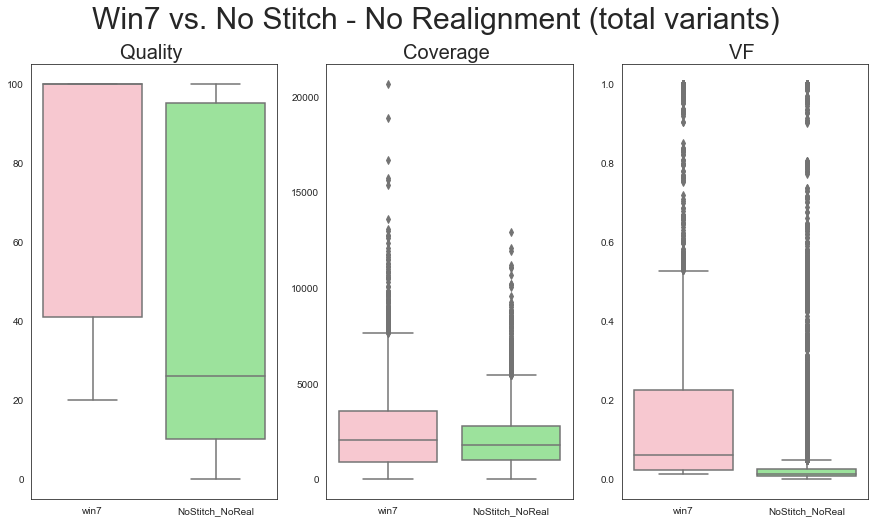

In [10]:
sns.set_style("white")
plt.figure(dpi=800)
plt.figure(figsize = (15,8))
my_pal = {"win7": "pink", "NoStitch_NoReal": "lightgreen"}

plt.suptitle('Win7 vs. No Stitch - No Realignment (total variants)', fontsize=30)

DataForPlot = win7_NoStitch_NoReal

plt.subplot(1,3,1)
ax=sns.boxplot(x=DataForPlot["Indicator"], y=DataForPlot["QUAL"], palette=my_pal )
ax.set_title('Quality ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')

plt.subplot(1,3,2)
ax=sns.boxplot(x=DataForPlot["Indicator"], y=DataForPlot["Coverage"], palette=my_pal)
ax.set_title('Coverage ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')

plt.subplot(1,3,3)
ax=sns.boxplot(x=DataForPlot["Indicator"], y=DataForPlot["VF"], palette=my_pal)
ax.set_title('VF ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')
hide_toggle()

Quality in *No Stitch No Realignment* is lower than in win7. As it was seen in the JTHHC analysis, the reason for this is because win10 pipelines do not filter and do not discard variants with low quality while these variants are not called in the win7 version. This large number of low-quality variants drops the mean of the quality. We will see later how we explain this fact when doing the same analysis with only common variants, in which the means are mostly equal.


A similar thing happened with VF. This is because there is a relation between quality and VF. The Phred-scaled quality scores involve an estimate of error, the error is the probability that the bases are called incorrectly by the sequencer. If the VF in a specific variant is very high, that means that the alt base has been read many times, decreasing the probability of calling that variant by error and (according to the formula Q = -10logE) increasing the quality. [Illumina documentation about quality measurements.](https://support.illumina.com/content/dam/illumina-support/help/Illumina_DRAGEN_Bio_IT_Platform_v3_7_1000000141465/Content/SW/Informatics/Dragen/QUAL_QD_GQ_Formulation_fDG.htm)

Coverage is very similar between win7 and win10 in this graph. However, we will explore later the differences found between win7 and win10 pipelines that are not seen in this graph.





I have take this opportunity to explore some of the issues behind the variant detection accuracy. In [this paper](https://pubmed.ncbi.nlm.nih.gov/23176052/#:~:text=This%20phenomenon%20is%20known%20as,possible%20causes%20of%20strand%20bias.&text=Conclusion%3A%20Extreme%20strand%20bias%20indicates,false%2Dpositive%20rate%20for%20SNPs.) I have been reading about the effect of strand bias in Illumina short-read sequence output. Strand bias (in this context) is a sequencing bias in which one sequence strand is favored over the other. As a consequence, an incorrect evaluation of the amount of evidence observed for one allele against the other can happen. In the paper read, they focused on when the genotype inferred from the positive strand and the negative strand disagree.

##  Strand bias examples from real data

From: The effect of strand bias in Illumina short-read sequencing data

![Image of Yaktocat](https://www.researchgate.net/profile/David-Samuels-4/publication/233766236/figure/tbl1/AS:669684840030228@1536676716537/Strand-bias-examples-from-real-data.png)

They do genotyping quality control to evaluate the effect of strand bias by using three tools/methods that provide bias scores for each SNP identified. They conclude with:

- 1) Strand bias occurs randomly across different samples and can be produced by post-analysis procedures.
- 2) Strand bias can have a false positive inference, especially in heterozygous genotype calls.
- 3) They recommend precaution when applying strand bias as a filter.


## Quality, Coverage and VF comparison (Barplot)

<Figure size 4800x3200 with 0 Axes>

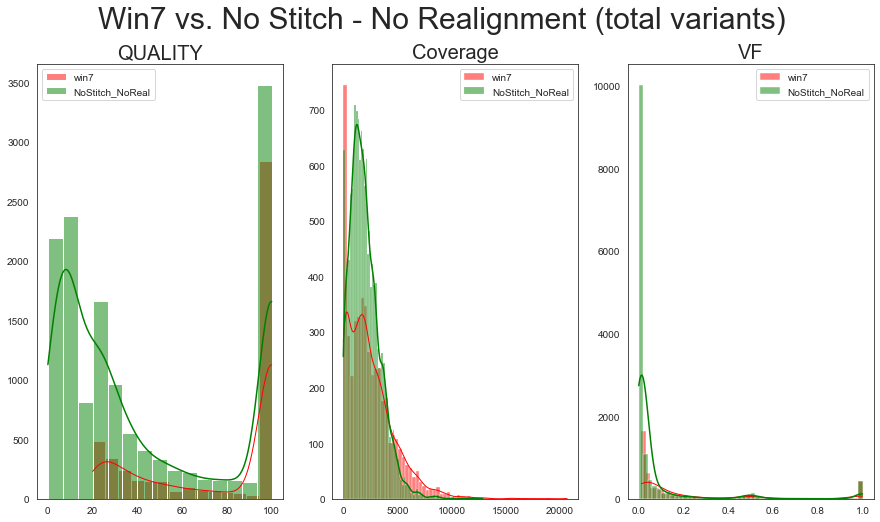

In [11]:
sns.set_style("white")
plt.figure(dpi=800)
plt.figure(figsize = (15,8))
plt.suptitle('Win7 vs. No Stitch - No Realignment (total variants)', fontsize=30)

ax1 = plt.subplot(1,3,1)
ax1 = sns.histplot(data=win7, x="QUAL", color="red", label="win7", kde=True)
ax1 = sns.histplot(data=NoStitch_NoReal, x="QUAL", color="green", label="NoStitch_NoReal", kde=True)
ax1.lines[0].set(linewidth=1)
ax1.set_title("QUALITY",size=20)
ax1.set_xlabel('', size=100)
ax1.set_ylabel('', size=20)
plt.legend() 

ax = plt.subplot(1,3,2)
ax = sns.histplot(data=win7, x="Coverage", color="red", label="win7", kde=True)
ax = sns.histplot(data=NoStitch_NoReal, x="Coverage", color="green", label="NoStitch_NoReal", kde=True)
ax.lines[0].set(linewidth=1)
ax.set_title("Coverage",size=20)
ax.set_xlabel('', size=100)
ax.set_ylabel('', size=20)
plt.legend() 

ax2 = plt.subplot(1,3,3)
ax2 = sns.histplot(data=win7, x="VF", color="red", label="win7", kde=True,bins = 50)
ax2 = sns.histplot(data=NoStitch_NoReal, x="VF", color="green", label="NoStitch_NoReal", kde=True,bins = 50)
ax2.lines[0].set(linewidth=1)
ax2.set_title("VF",size=20)

ax2.set_xlabel('', size=100)
ax2.set_ylabel('', size=20)
plt.legend() 

hide_toggle()

These bar plots support our previous comments. The quality graph shows a significant number of variants with very low quality (0 to 20 on the x-axis). We can also see a high proportion of variants in both win7 and win10 datasets with the highest quality.

Again, we can see in the VF graph a large proportion of win10-variants with the lowest variant frequency. Apart from these ones, the distribution of variants between win7 and win10 is similar.

With respect to coverage, win10 data shows a higher distribution of coverage. 

## Distribution of variants based on the atribute FILTER.

<Figure size 4800x3200 with 0 Axes>

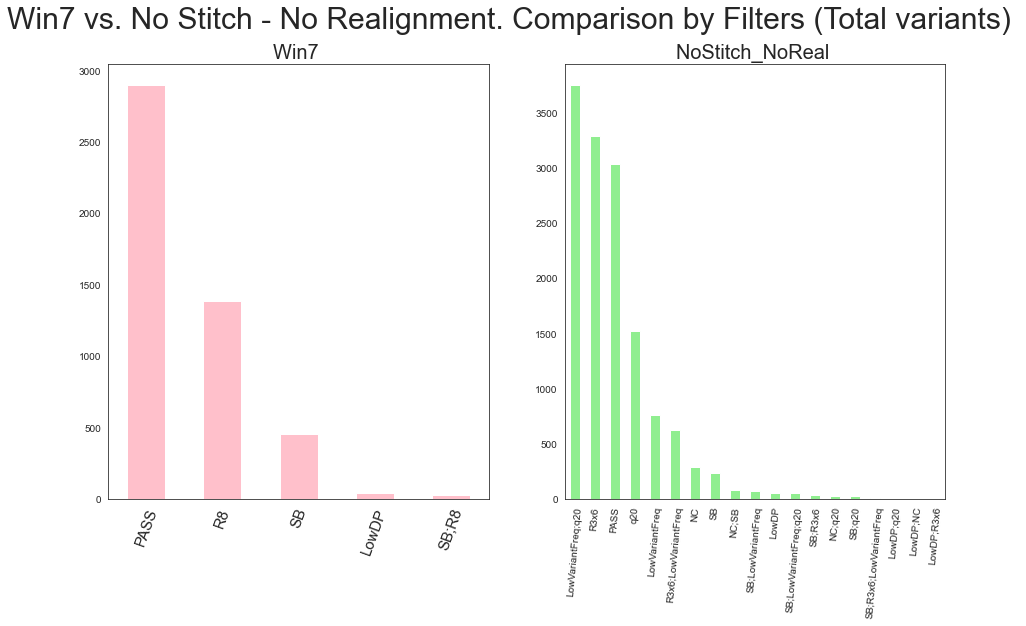

In [12]:
sns.set_style("white")
plt.figure(dpi=800)
plt.figure(figsize = (15,8))

plt.suptitle('Win7 vs. No Stitch - No Realignment. Comparison by Filters (Total variants) ', fontsize=30)

ax = plt.subplot(1,2,1)
win7["FILTER"].value_counts().plot.bar(color="pink")
ax.set_title('Win7 ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')
plt.xticks(rotation=70,size=15)

plt.subplot(1,2,2)

ax = NoStitch_NoReal["FILTER"].value_counts().plot.bar(color="lightgreen")
ax.set_title('NoStitch_NoReal ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')
plt.xticks(rotation=85,size=10)

hide_toggle()

Win7 pipeline classifies variants into 5 groups while win10 organises variants in 20 groups. It is difficult to establish a comparison when variants are classified in different ways. However, we can see how there is a similar proportion of variants that pass all filters (PASS) in both plots. The number of PASS-variants in both datasets approximately coincides with the high-quality variants shown in the previous quality plot. 




<a class="anchor" id="1.2"></a>

### Common variants

Now, we are going to repeat the same approach but exclude the variants that do not math in win7 and win10 datasets in order to do the same analysis but now with common variants. To do this I am going to use the data frames that I used for the Venn diagram and combine them in one *common_variants_win7_NoStitch_NoReal* data frame.


In [15]:
# Comparison of common variants
common_variants_win7_NoStitch_NoReal = pd.merge(win7, NoStitch_NoRealm, left_on='Sample_ID', right_on='10Sample_ID').drop('10Sample_ID', axis=1)
common_variants_win7_NoStitch_NoReal.drop('Indicator', axis=1, inplace=True)
print("Common variants data:")
display(common_variants_win7_NoStitch_NoReal.head(2))
hide_toggle()

Common variants data:


,Sample_ID,QUAL,FILTER,GT,AD,SB,Coverage,VF,10QUAL,10FILTER,10GT,10AD,10SB,10VF,10Coverage
0,W2114579chr1:36933574T>G,100.0,SB,0/1,"1403,170",0.0000,1573,0.108074,33,SB,0/1,"668,10",-0.4314,0.014749,678
1,W2114579chr2:25458713A>G,22.0,PASS,0/1,"9308,120",-12.5434,9428,0.012728,67,PASS,0/1,"4999,65",-74.6713,0.012836,5064


With this dataset, we can no se the differences between the coverage of both pipelines.

## Coverage distribution in common variants

<Figure size 4800x3200 with 0 Axes>

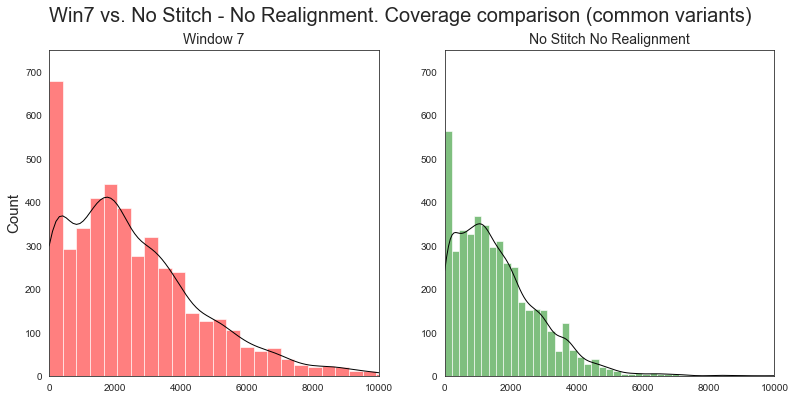

In [16]:
plt.figure(dpi=800)
plt.figure(figsize = (13,6))
plt.suptitle('Win7 vs. No Stitch - No Realignment. Coverage comparison (common variants)', fontsize=20)

DataForPlot = common_variants_win7_NoStitch_NoReal

plt.subplot(1,2,1)
ax1 = sns.histplot(DataForPlot["Coverage"],kde=True,color="r",bins = 50)
ax1.lines[0].set_color('black')
ax1.lines[0].set(linewidth=1)
ax1.set_title("Window 7", size=14)
ax1.set_ylim([0, 750])
ax1.set_xlim([0, 10000])
ax1.set_xlabel('', size=100)
ax1.set_ylabel('Count', size=15)


plt.subplot(1,2,2)
ax2 = sns.histplot(DataForPlot["10Coverage"],kde=True, color="g",bins = 50)
ax2.lines[0].set_color('black')
ax2.lines[0].set(linewidth=1)
ax2.set_title("No Stitch No Realignment",size=14)
ax2.set_ylim([0, 750])
ax2.set_xlim([0, 10000])
ax2.set_xlabel('', size=100)
ax2.set_ylabel('', size=20)

plt.show()
hide_toggle()

The shape of the distribution line is similar in both graphs. However, the graph on the left shows a homogeneous higher distribution, which means that in general the same variants have greater coverage in win7 than in win10. The reason why this occurs is beyond my understanding.

## Coverage, Quality and VF boxplots in common variants

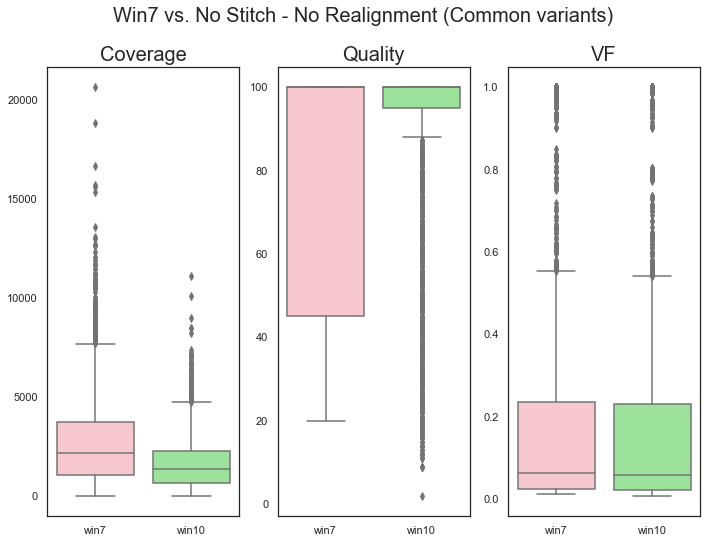

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
plt.suptitle('Win7 vs. No Stitch - No Realignment (Common variants)', fontsize=20)

DataForPlot = common_variants_win7_NoStitch_NoReal

plt.subplot(1,3,1)
my_pal = {"Coverage": "pink", "10Coverage": "lightgreen"}
ax = sns.boxplot(data=DataForPlot[["Coverage","10Coverage"]],palette=my_pal)
ax.set_xticklabels(["win7","win10"])
ax.set_title("Coverage",size=20)


plt.subplot(1,3,2)
my_pal = {"QUAL": "pink", "10QUAL": "lightgreen"}
ax = sns.boxplot(data=DataForPlot[["QUAL","10QUAL"]], palette=my_pal)
ax.set_xticklabels(["win7","win10"])
ax.set_title("Quality",size=20)

plt.subplot(1,3,3)
my_pal = {"VF": "pink", "10VF": "lightgreen"}
ax = sns.boxplot(data=DataForPlot[["VF","10VF"]], palette=my_pal)
ax.set_xticklabels(["win7","win10"])
ax.set_title("VF",size=20)

hide_toggle()

As mentioned above, the mean of coverage in win7 is superior than in win10.

Win10 quality is higher now than quality win7.

VF remains the same in common variants as well as in the analysis with the total number of variants.

<a class="anchor" id="1.2.1"></a>

### Common variants (Differences)

Next, we want to see the distribution of the differences between the Coverage of the win7 and win10 output.

In [18]:
# These lines do this calculation and save the values in a new column.

print("Coverage differences between win7 and No Stitch - No Realignment common variants")
common_variants_win7_NoStitch_NoReal["Coverage-diff"] = common_variants_win7_NoStitch_NoReal["Coverage"] - common_variants_win7_NoStitch_NoReal["10Coverage"]
#display(common_variants_win7_NoStitch_NoReal.head(1))
hide_toggle()

Coverage differences between win7 and No Stitch - No Realignment common variants


## A boxplot of these differences.

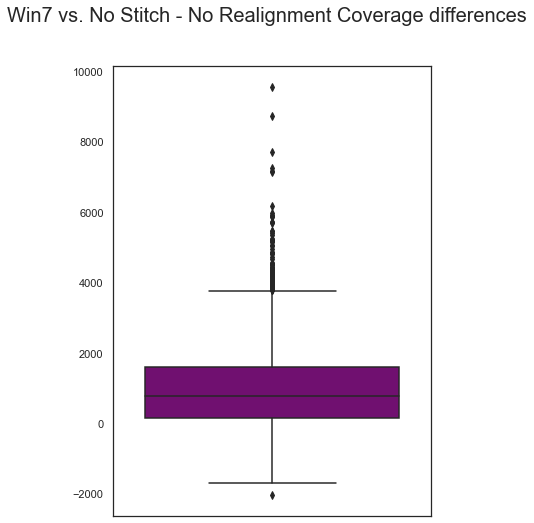

In [19]:
sns.set(rc={'figure.figsize':(5.7,8.27)})
sns.set_style("white")
plt.suptitle('Win7 vs. No Stitch - No Realignment Coverage differences', fontsize=20)

my_pal = {0: "purple"} # I dont know why this is called 0
ax = sns.boxplot(data=common_variants_win7_NoStitch_NoReal["Coverage-diff"],palette=my_pal)
ax.set_xticklabels([""])

hide_toggle()

I believe that the differences are significant. This graph basically says that the same variants have been read on average 1000 times more in the win7 version than in the win10 version.


Now I do the same analysis with the remaining win 10 versions. I show the graphics but I do not make any comment because the graphs are basically identical with the ones already commented.

# Win7 vs. Stitch - No Realignment <a class="anchor" id="2"></a>


****
### Total variants <a class="anchor" id="2.1"></a>

Concatenation of data frames with indicador to create the following plots.

In [20]:
print("Win7 and Stitch - No Realignment data with indicators")
Stitch_NoReal.insert(0, 'Indicator', 'Stitch_NoReal')
frames = [win7, Stitch_NoReal]
win7_Stitch_NoReal = pd.concat(frames)
#display(win7_Stitch_NoReal)
hide_toggle()

Win7 and Stitch - No Realignment data with indicators


<Figure size 4560x6616 with 0 Axes>

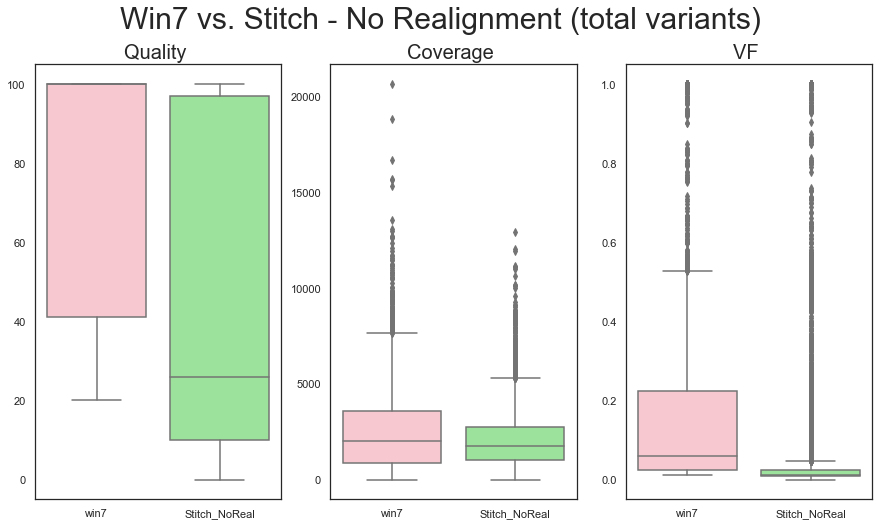

In [21]:
sns.set_style("white")
plt.figure(dpi=800)
plt.figure(figsize = (15,8))
my_pal = {"win7": "pink", "Stitch_NoReal": "lightgreen"}

plt.suptitle('Win7 vs. Stitch - No Realignment (total variants)', fontsize=30)

DataForPlot = win7_Stitch_NoReal

plt.subplot(1,3,1)
ax=sns.boxplot(x=DataForPlot["Indicator"], y=DataForPlot["QUAL"], palette=my_pal )
ax.set_title('Quality ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')

plt.subplot(1,3,2)
ax=sns.boxplot(x=DataForPlot["Indicator"], y=DataForPlot["Coverage"], palette=my_pal)
ax.set_title('Coverage ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')

plt.subplot(1,3,3)
ax=sns.boxplot(x=DataForPlot["Indicator"], y=DataForPlot["VF"], palette=my_pal)
ax.set_title('VF ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')
hide_toggle()

<Figure size 4560x6616 with 0 Axes>

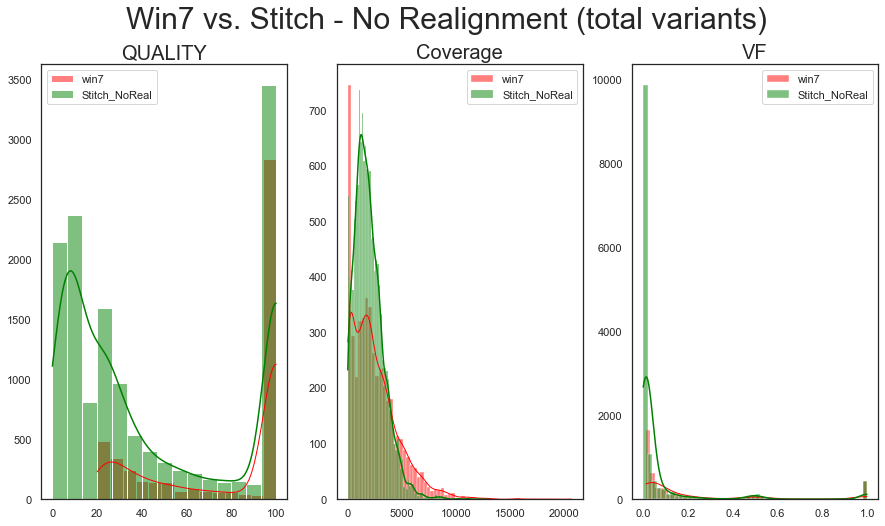

In [22]:
sns.set_style("white")
plt.figure(dpi=800)
plt.figure(figsize = (15,8))
plt.suptitle('Win7 vs. Stitch - No Realignment (total variants)', fontsize=30)

ax1 = plt.subplot(1,3,1)
ax1 = sns.histplot(data=win7, x="QUAL", color="red", label="win7", kde=True)
ax1 = sns.histplot(data=Stitch_NoReal, x="QUAL", color="green", label="Stitch_NoReal", kde=True)
ax1.lines[0].set(linewidth=1)
ax1.set_title("QUALITY",size=20)
ax1.set_xlabel('', size=100)
ax1.set_ylabel('', size=20)
plt.legend() 

ax = plt.subplot(1,3,2)
ax = sns.histplot(data=win7, x="Coverage", color="red", label="win7", kde=True)
ax = sns.histplot(data=Stitch_NoReal, x="Coverage", color="green", label="Stitch_NoReal", kde=True)
ax.lines[0].set(linewidth=1)
ax.set_title("Coverage",size=20)
ax.set_xlabel('', size=100)
ax.set_ylabel('', size=20)
plt.legend() 

ax2 = plt.subplot(1,3,3)
ax2 = sns.histplot(data=win7, x="VF", color="red", label="win7", kde=True,bins = 50)
ax2 = sns.histplot(data=Stitch_NoReal, x="VF", color="green", label="Stitch_NoReal", kde=True,bins = 50)
ax2.lines[0].set(linewidth=1)
ax2.set_title("VF",size=20)

ax2.set_xlabel('', size=100)
ax2.set_ylabel('', size=20)
plt.legend() 

hide_toggle()

<Figure size 4560x6616 with 0 Axes>

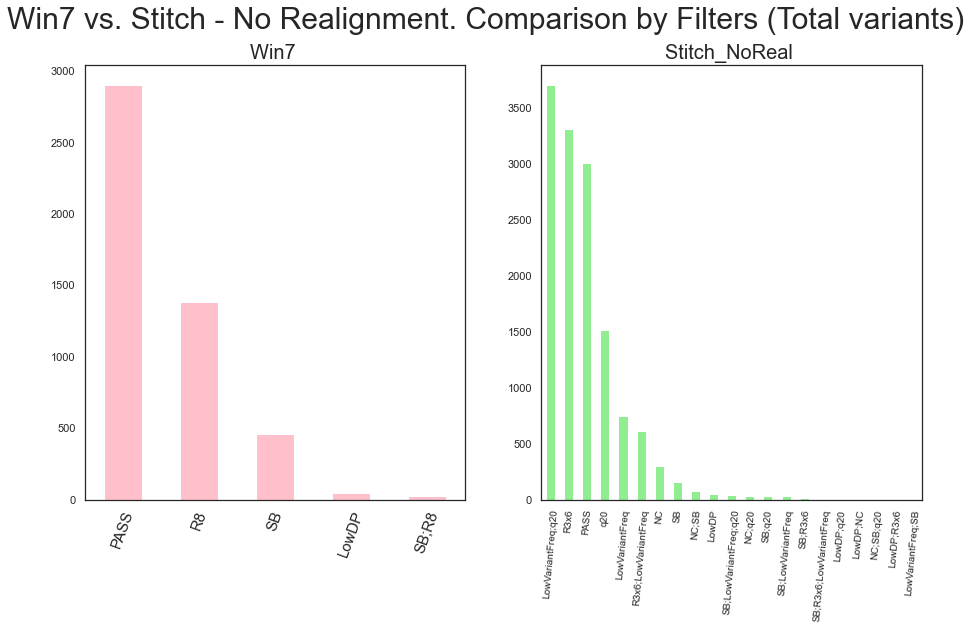

In [23]:
sns.set_style("white")
plt.figure(dpi=800)
plt.figure(figsize = (15,8))

plt.suptitle('Win7 vs. Stitch - No Realignment. Comparison by Filters (Total variants) ', fontsize=30)

ax = plt.subplot(1,2,1)
win7["FILTER"].value_counts().plot.bar(color="pink")
ax.set_title('Win7 ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')
plt.xticks(rotation=70,size=15)

plt.subplot(1,2,2)
ax = Stitch_NoReal["FILTER"].value_counts().plot.bar(color="lightgreen")
ax.set_title('Stitch_NoReal ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')
plt.xticks(rotation=85,size=10)

hide_toggle()

<a class="anchor" id="2.2"></a>

### Common variants
The win10 ID  are slighly different compared with win7 ID.

To match both we need first to change a bit win10 ID variants. 

In [25]:
# Comparison of common variants
common_variants_win7_Stitch_NoReal = pd.merge(win7, Stitch_NoRealm, left_on='Sample_ID', right_on='10Sample_ID').drop('10Sample_ID', axis=1)
common_variants_win7_Stitch_NoReal.drop('Indicator', axis=1, inplace=True)
print("Common variants data:")
#display(common_variants_win7_Stitch_NoReal.head(2))
hide_toggle()

Common variants data:


<Figure size 4560x6616 with 0 Axes>

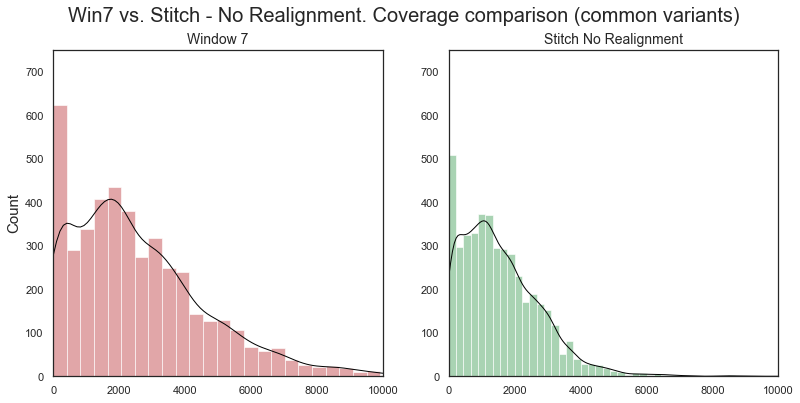

In [26]:
plt.figure(dpi=800)
plt.figure(figsize = (13,6))
plt.suptitle('Win7 vs. Stitch - No Realignment. Coverage comparison (common variants)', fontsize=20)

DataForPlot = common_variants_win7_Stitch_NoReal

plt.subplot(1,2,1)
ax1 = sns.histplot(DataForPlot["Coverage"],kde=True,color="r",bins = 50)
ax1.lines[0].set_color('black')
ax1.lines[0].set(linewidth=1)
ax1.set_title("Window 7", size=14)
ax1.set_ylim([0, 750])
ax1.set_xlim([0, 10000])
ax1.set_xlabel('', size=100)
ax1.set_ylabel('Count', size=15)


plt.subplot(1,2,2)
ax2 = sns.histplot(DataForPlot["10Coverage"],kde=True, color="g",bins = 50)
ax2.lines[0].set_color('black')
ax2.lines[0].set(linewidth=1)
ax2.set_title("Stitch No Realignment",size=14)
ax2.set_ylim([0, 750])
ax2.set_xlim([0, 10000])
ax2.set_xlabel('', size=100)
ax2.set_ylabel('', size=20)

plt.show()
hide_toggle()

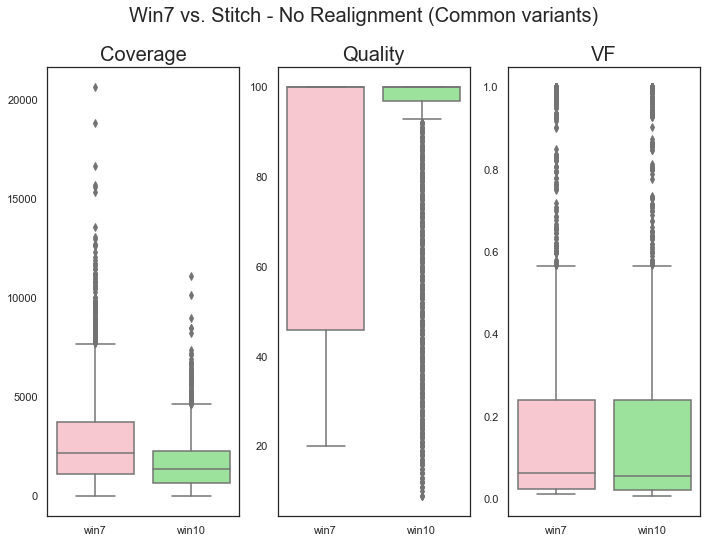

In [27]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
plt.suptitle('Win7 vs. Stitch - No Realignment (Common variants)', fontsize=20)

DataForPlot = common_variants_win7_Stitch_NoReal

plt.subplot(1,3,1)
my_pal = {"Coverage": "pink", "10Coverage": "lightgreen"}
ax = sns.boxplot(data=DataForPlot[["Coverage","10Coverage"]],palette=my_pal)
ax.set_xticklabels(["win7","win10"])
ax.set_title("Coverage",size=20)


plt.subplot(1,3,2)
my_pal = {"QUAL": "pink", "10QUAL": "lightgreen"}
ax = sns.boxplot(data=DataForPlot[["QUAL","10QUAL"]], palette=my_pal)
ax.set_xticklabels(["win7","win10"])
ax.set_title("Quality",size=20)

plt.subplot(1,3,3)
my_pal = {"VF": "pink", "10VF": "lightgreen"}
ax = sns.boxplot(data=DataForPlot[["VF","10VF"]], palette=my_pal)
ax.set_xticklabels(["win7","win10"])
ax.set_title("VF",size=20)

hide_toggle()

<a class="anchor" id="2.2.1"></a>

### Common variants (Differences)

In [28]:
print("Coverage differences between win7 and Stitch - No Realignment common variants")
common_variants_win7_Stitch_NoReal["Coverage-diff"] = common_variants_win7_Stitch_NoReal["Coverage"] - common_variants_win7_Stitch_NoReal["10Coverage"]
#display(common_variants_win7_Stitch_NoReal.head(1))
hide_toggle()

Coverage differences between win7 and Stitch - No Realignment common variants


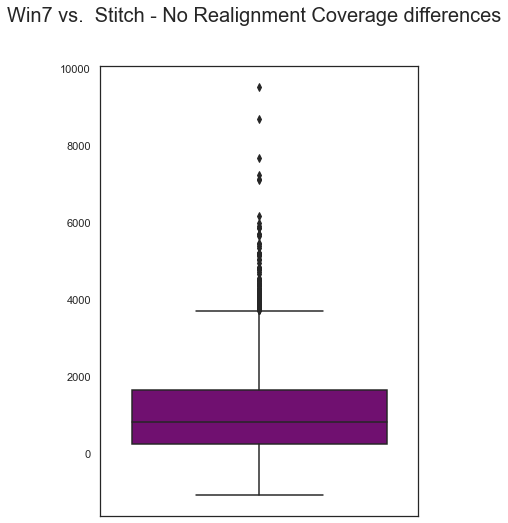

In [29]:
sns.set(rc={'figure.figsize':(5.7,8.27)})
sns.set_style("white")
plt.suptitle('Win7 vs.  Stitch - No Realignment Coverage differences', fontsize=20)

my_pal = {0: "purple"} # I dont know why this is called 0
ax = sns.boxplot(data=common_variants_win7_Stitch_NoReal["Coverage-diff"],palette=my_pal)
ax.set_xticklabels([""])
hide_toggle()

# Win7 vs. Stitch - Realignment <a class="anchor" id="3"></a>


****
### Total variants <a class="anchor" id="3.1"></a>

In [30]:
print("Win7 and Stitch - Realignment data with indicators")
Stitch_Real.insert(0, 'Indicator', 'Stitch_Real')
frames = [win7, Stitch_Real]
win7_Stitch_Real = pd.concat(frames)
#display(win7_Stitch_Real)
hide_toggle()

Win7 and Stitch - Realignment data with indicators


<Figure size 4560x6616 with 0 Axes>

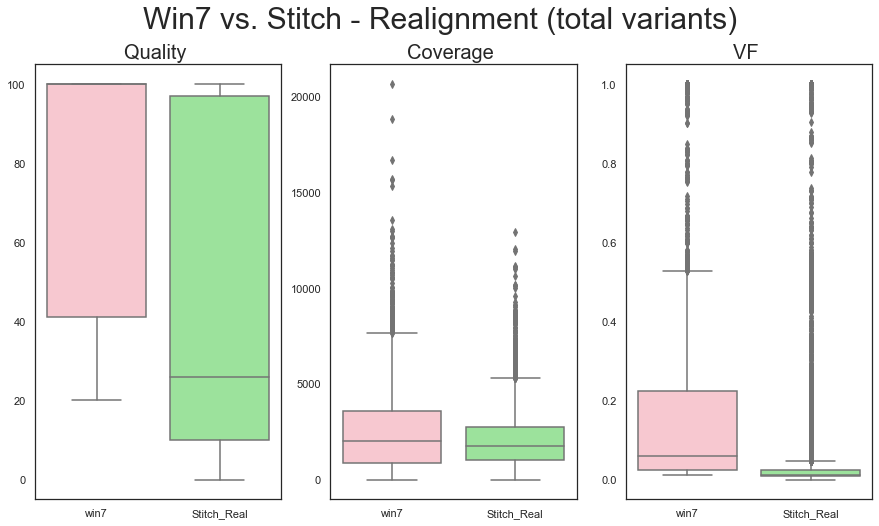

In [31]:
sns.set_style("white")
plt.figure(dpi=800)
plt.figure(figsize = (15,8))
my_pal = {"win7": "pink", "Stitch_Real": "lightgreen"}

plt.suptitle('Win7 vs. Stitch - Realignment (total variants)', fontsize=30)

DataForPlot = win7_Stitch_Real

plt.subplot(1,3,1)
ax=sns.boxplot(x=DataForPlot["Indicator"], y=DataForPlot["QUAL"], palette=my_pal )
ax.set_title('Quality ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')

plt.subplot(1,3,2)
ax=sns.boxplot(x=DataForPlot["Indicator"], y=DataForPlot["Coverage"], palette=my_pal)
ax.set_title('Coverage ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')

plt.subplot(1,3,3)
ax=sns.boxplot(x=DataForPlot["Indicator"], y=DataForPlot["VF"], palette=my_pal)
ax.set_title('VF ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')
hide_toggle()

<Figure size 4560x6616 with 0 Axes>

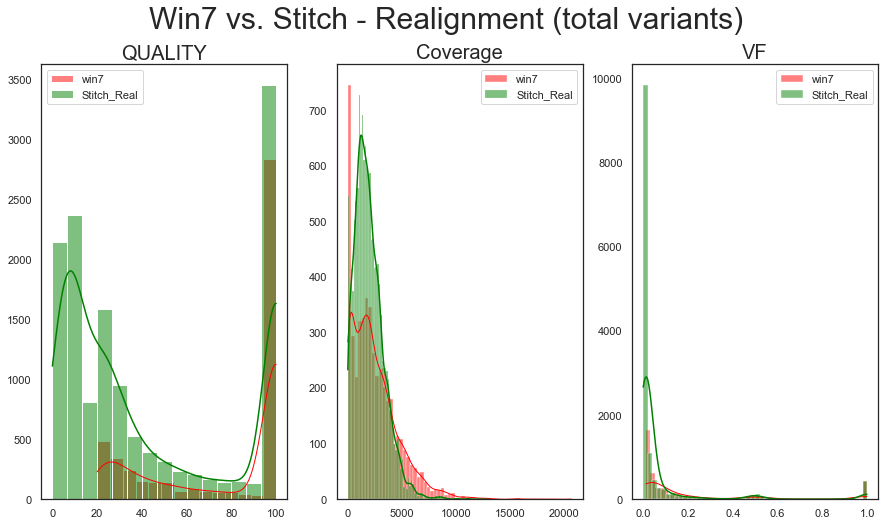

In [32]:
sns.set_style("white")
plt.figure(dpi=800)
plt.figure(figsize = (15,8))
plt.suptitle('Win7 vs. Stitch - Realignment (total variants)', fontsize=30)

ax1 = plt.subplot(1,3,1)
ax1 = sns.histplot(data=win7, x="QUAL", color="red", label="win7", kde=True)
ax1 = sns.histplot(data=Stitch_Real, x="QUAL", color="green", label="Stitch_Real", kde=True)
ax1.lines[0].set(linewidth=1)
ax1.set_title("QUALITY",size=20)
ax1.set_xlabel('', size=100)
ax1.set_ylabel('', size=20)
plt.legend() 

ax = plt.subplot(1,3,2)
ax = sns.histplot(data=win7, x="Coverage", color="red", label="win7", kde=True)
ax = sns.histplot(data=Stitch_Real, x="Coverage", color="green", label="Stitch_Real", kde=True)
ax.lines[0].set(linewidth=1)
ax.set_title("Coverage",size=20)
ax.set_xlabel('', size=100)
ax.set_ylabel('', size=20)
plt.legend() 

ax2 = plt.subplot(1,3,3)
ax2 = sns.histplot(data=win7, x="VF", color="red", label="win7", kde=True,bins = 50)
ax2 = sns.histplot(data=Stitch_Real, x="VF", color="green", label="Stitch_Real", kde=True,bins = 50)
ax2.lines[0].set(linewidth=1)
ax2.set_title("VF",size=20)

ax2.set_xlabel('', size=100)
ax2.set_ylabel('', size=20)
plt.legend() 

hide_toggle()

<Figure size 4560x6616 with 0 Axes>

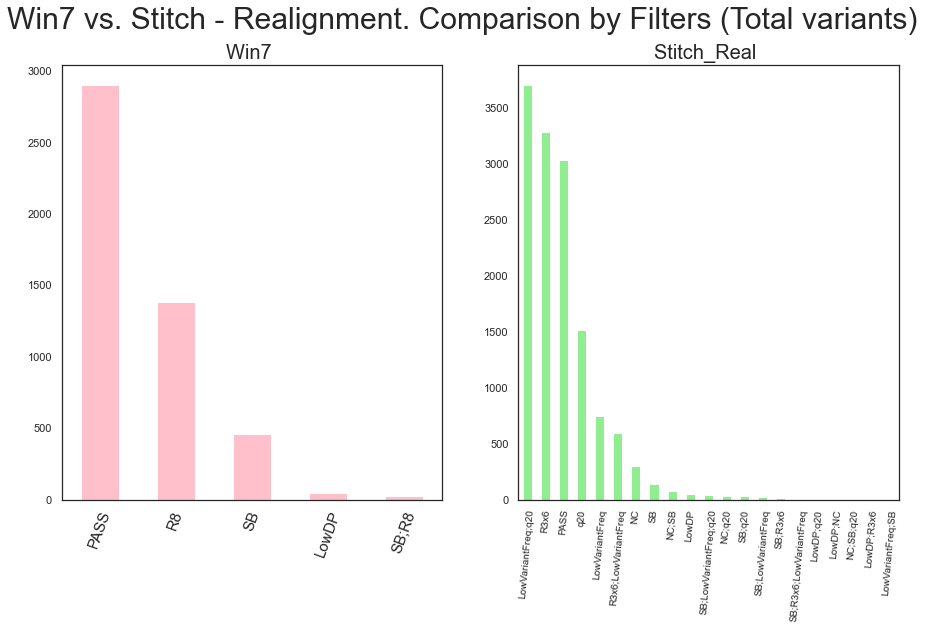

In [33]:
sns.set_style("white")
plt.figure(dpi=800)
plt.figure(figsize = (15,8))

plt.suptitle('Win7 vs. Stitch - Realignment. Comparison by Filters (Total variants) ', fontsize=30)

ax = plt.subplot(1,2,1)
win7["FILTER"].value_counts().plot.bar(color="pink")
ax.set_title('Win7 ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')
plt.xticks(rotation=70,size=15)

plt.subplot(1,2,2)

ax = Stitch_Real["FILTER"].value_counts().plot.bar(color="lightgreen")
ax.set_title('Stitch_Real ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')
plt.xticks(rotation=85,size=10)

hide_toggle()

<a class="anchor" id="3.2"></a>

### Common variants


In [35]:
# Comparison of common variants
common_variants_win7_Stitch_Real = pd.merge(win7, Stitch_Realm, left_on='Sample_ID', right_on='10Sample_ID').drop('10Sample_ID', axis=1)
common_variants_win7_Stitch_Real.drop('Indicator', axis=1, inplace=True)
print("Common variants data:")
#display(common_variants_win7_Stitch_Real.head(2))
hide_toggle()

Common variants data:


<Figure size 4560x6616 with 0 Axes>

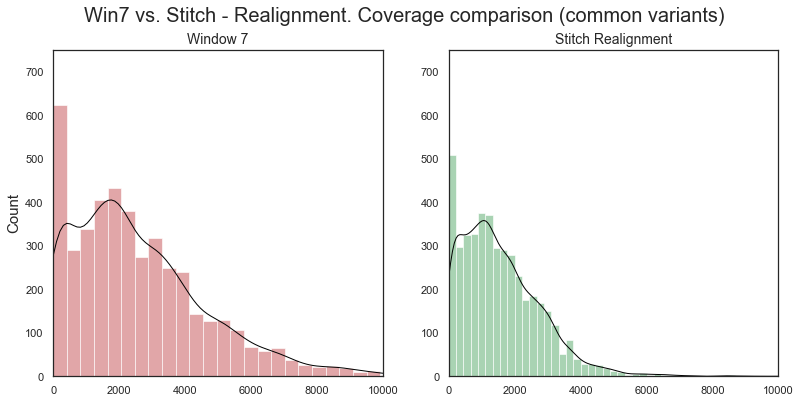

In [36]:
plt.figure(dpi=800)
plt.figure(figsize = (13,6))
plt.suptitle('Win7 vs. Stitch - Realignment. Coverage comparison (common variants)', fontsize=20)

DataForPlot = common_variants_win7_Stitch_Real

plt.subplot(1,2,1)
ax1 = sns.histplot(DataForPlot["Coverage"],kde=True,color="r",bins = 50)
ax1.lines[0].set_color('black')
ax1.lines[0].set(linewidth=1)
ax1.set_title("Window 7", size=14)
ax1.set_ylim([0, 750])
ax1.set_xlim([0, 10000])
ax1.set_xlabel('', size=100)
ax1.set_ylabel('Count', size=15)


plt.subplot(1,2,2)
ax2 = sns.histplot(DataForPlot["10Coverage"],kde=True, color="g",bins = 50)
ax2.lines[0].set_color('black')
ax2.lines[0].set(linewidth=1)
ax2.set_title("Stitch Realignment",size=14)
ax2.set_ylim([0, 750])
ax2.set_xlim([0, 10000])
ax2.set_xlabel('', size=100)
ax2.set_ylabel('', size=20)

plt.show()
hide_toggle()

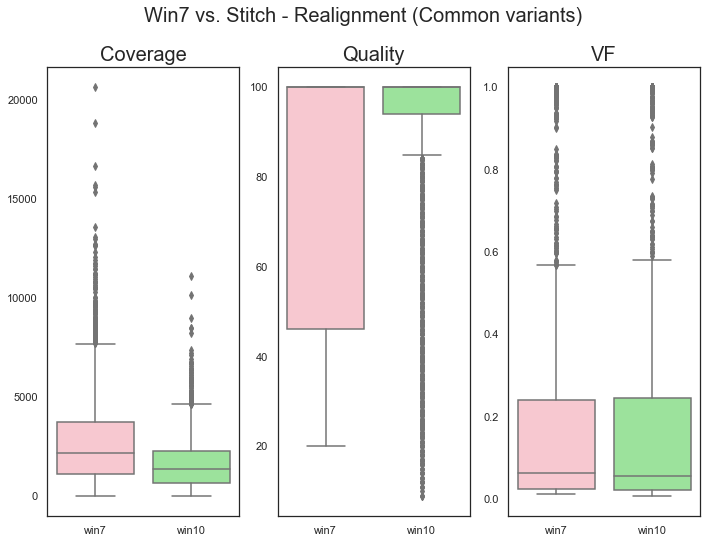

In [37]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
plt.suptitle('Win7 vs. Stitch - Realignment (Common variants)', fontsize=20)

DataForPlot = common_variants_win7_Stitch_Real

plt.subplot(1,3,1)
my_pal = {"Coverage": "pink", "10Coverage": "lightgreen"}
ax = sns.boxplot(data=DataForPlot[["Coverage","10Coverage"]],palette=my_pal)
ax.set_xticklabels(["win7","win10"])
ax.set_title("Coverage",size=20)


plt.subplot(1,3,2)
my_pal = {"QUAL": "pink", "10QUAL": "lightgreen"}
ax = sns.boxplot(data=DataForPlot[["QUAL","10QUAL"]], palette=my_pal)
ax.set_xticklabels(["win7","win10"])
ax.set_title("Quality",size=20)

plt.subplot(1,3,3)
my_pal = {"VF": "pink", "10VF": "lightgreen"}
ax = sns.boxplot(data=DataForPlot[["VF","10VF"]], palette=my_pal)
ax.set_xticklabels(["win7","win10"])
ax.set_title("VF",size=20)

hide_toggle()

<a class="anchor" id="3.2.1"></a>

### Common variants (Differences)

In [38]:
print("Coverage differences between win7 and Stitch - Realignment common variants")
common_variants_win7_Stitch_Real["Coverage-diff"] = common_variants_win7_Stitch_Real["Coverage"] - common_variants_win7_Stitch_Real["10Coverage"]
#display(common_variants_win7_Stitch_Real.head(1))
hide_toggle()

Coverage differences between win7 and Stitch - Realignment common variants


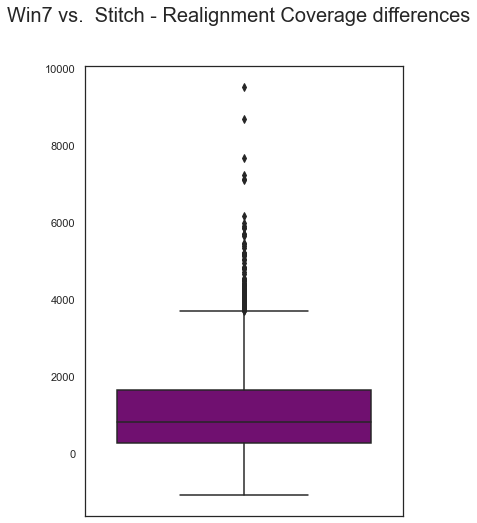

In [39]:
sns.set(rc={'figure.figsize':(5.7,8.27)})
sns.set_style("white")
plt.suptitle('Win7 vs.  Stitch - Realignment Coverage differences', fontsize=20)

my_pal = {0: "purple"} # I dont know why this is called 0
ax = sns.boxplot(data=common_variants_win7_Stitch_Real["Coverage-diff"],palette=my_pal)
ax.set_xticklabels([""])
hide_toggle()

# Win7 vs. No Stitch - Realignment <a class="anchor" id="4"></a>


****
### Total variants <a class="anchor" id="3.1"></a>

In [40]:
#print("Win7 and No Stitch - Realignment data with indicators")
NoStitch_Real.insert(0, 'Indicator', 'NoStitch_Real')
frames = [win7, NoStitch_Real]
win7_NoStitch_Real = pd.concat(frames)
#display(win7_NoStitch_Real)
hide_toggle()

<Figure size 4560x6616 with 0 Axes>

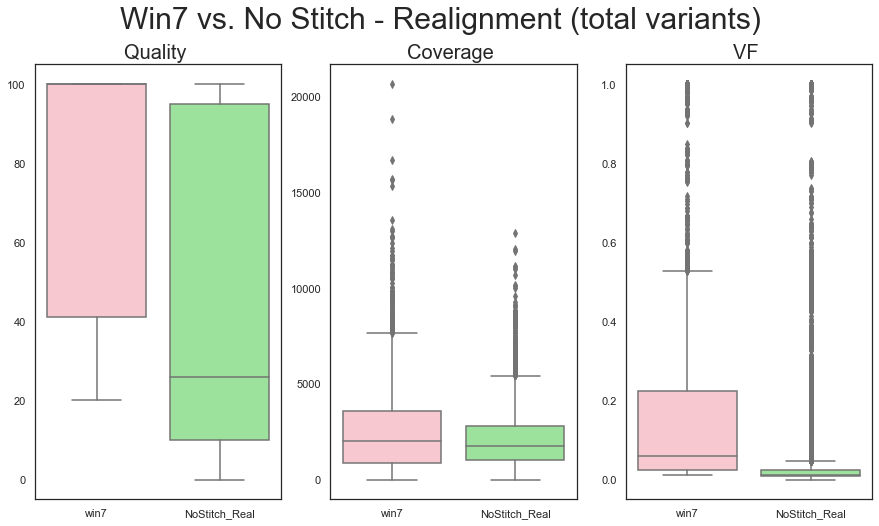

In [41]:
sns.set_style("white")
plt.figure(dpi=800)
plt.figure(figsize = (15,8))
my_pal = {"win7": "pink", "NoStitch_Real": "lightgreen"}

plt.suptitle('Win7 vs. No Stitch - Realignment (total variants)', fontsize=30)

DataForPlot = win7_NoStitch_Real

plt.subplot(1,3,1)
ax=sns.boxplot(x=DataForPlot["Indicator"], y=DataForPlot["QUAL"], palette=my_pal )
ax.set_title('Quality ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')

plt.subplot(1,3,2)
ax=sns.boxplot(x=DataForPlot["Indicator"], y=DataForPlot["Coverage"], palette=my_pal)
ax.set_title('Coverage ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')

plt.subplot(1,3,3)
ax=sns.boxplot(x=DataForPlot["Indicator"], y=DataForPlot["VF"], palette=my_pal)
ax.set_title('VF ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')
hide_toggle()

<Figure size 4560x6616 with 0 Axes>

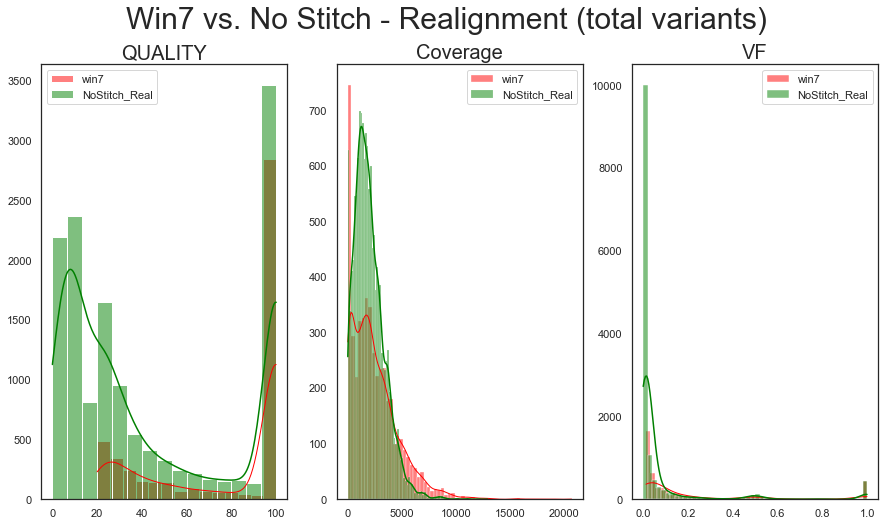

In [42]:
sns.set_style("white")
plt.figure(dpi=800)
plt.figure(figsize = (15,8))
plt.suptitle('Win7 vs. No Stitch - Realignment (total variants)', fontsize=30)

ax1 = plt.subplot(1,3,1)
ax1 = sns.histplot(data=win7, x="QUAL", color="red", label="win7", kde=True)
ax1 = sns.histplot(data=NoStitch_Real, x="QUAL", color="green", label="NoStitch_Real", kde=True)
ax1.lines[0].set(linewidth=1)
ax1.set_title("QUALITY",size=20)
ax1.set_xlabel('', size=100)
ax1.set_ylabel('', size=20)
plt.legend() 

ax = plt.subplot(1,3,2)
ax = sns.histplot(data=win7, x="Coverage", color="red", label="win7", kde=True)
ax = sns.histplot(data=NoStitch_Real, x="Coverage", color="green", label="NoStitch_Real", kde=True)
ax.lines[0].set(linewidth=1)
ax.set_title("Coverage",size=20)
ax.set_xlabel('', size=100)
ax.set_ylabel('', size=20)
plt.legend() 

ax2 = plt.subplot(1,3,3)
ax2 = sns.histplot(data=win7, x="VF", color="red", label="win7", kde=True,bins = 50)
ax2 = sns.histplot(data=NoStitch_Real, x="VF", color="green", label="NoStitch_Real", kde=True,bins = 50)
ax2.lines[0].set(linewidth=1)
ax2.set_title("VF",size=20)

ax2.set_xlabel('', size=100)
ax2.set_ylabel('', size=20)
plt.legend() 

hide_toggle()

<Figure size 4560x6616 with 0 Axes>

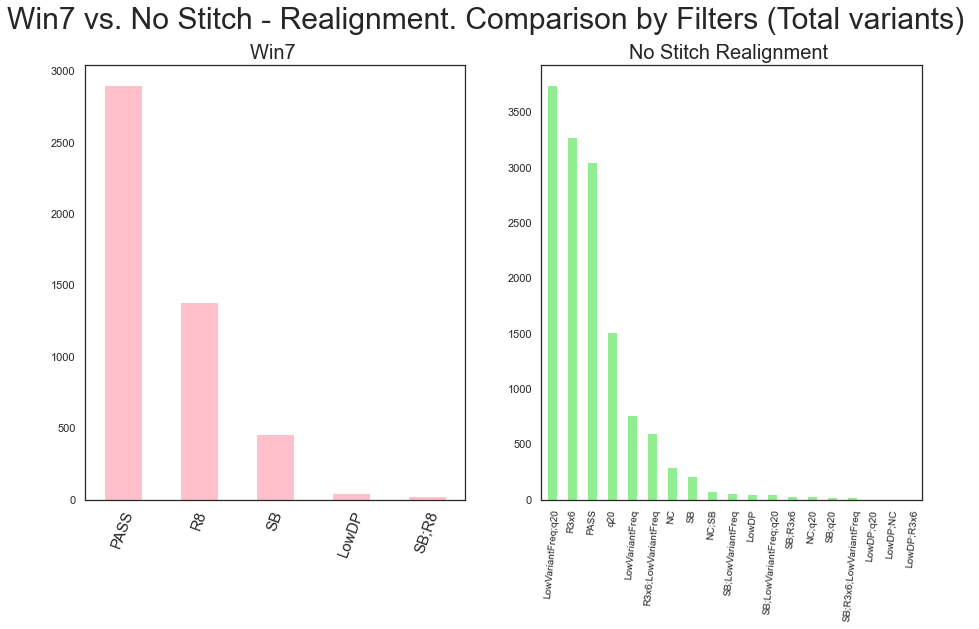

In [40]:
sns.set_style("white")
plt.figure(dpi=800)
plt.figure(figsize = (15,8))

plt.suptitle('Win7 vs. No Stitch - Realignment. Comparison by Filters (Total variants) ', fontsize=30)

ax = plt.subplot(1,2,1)
win7["FILTER"].value_counts().plot.bar(color="pink")
ax.set_title('Win7 ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')
plt.xticks(rotation=70,size=15)

plt.subplot(1,2,2)

ax = NoStitch_Real["FILTER"].value_counts().plot.bar(color="lightgreen")
ax.set_title('No Stitch Realignment ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')
plt.xticks(rotation=85,size=10)

hide_toggle()

<a class="anchor" id="3.2"></a>

### Common variants

In [43]:
# Comparison of common variants
common_variants_win7_NoStitch_Real = pd.merge(win7, NoStitch_Realm, left_on='Sample_ID', right_on='10Sample_ID').drop('10Sample_ID', axis=1)
common_variants_win7_NoStitch_Real.drop('Indicator', axis=1, inplace=True)
#print("Common variants data:")
#display(common_variants_win7_NoStitch_Real.head(2))
hide_toggle()

<Figure size 4560x6616 with 0 Axes>

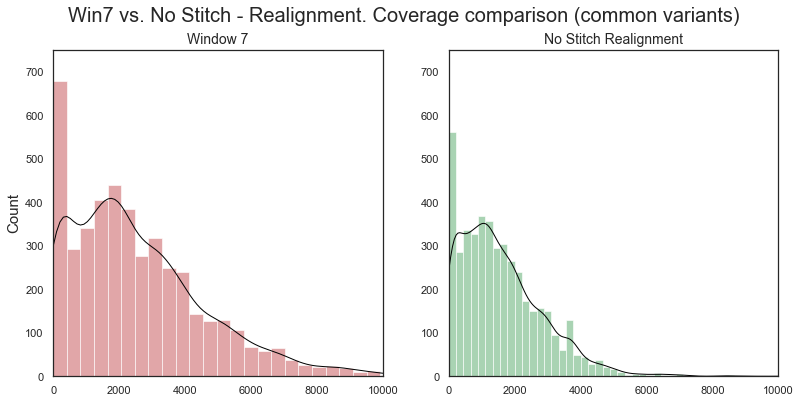

In [44]:
plt.figure(dpi=800)
plt.figure(figsize = (13,6))
plt.suptitle('Win7 vs. No Stitch - Realignment. Coverage comparison (common variants)', fontsize=20)

DataForPlot = common_variants_win7_NoStitch_Real

plt.subplot(1,2,1)
ax1 = sns.histplot(DataForPlot["Coverage"],kde=True,color="r",bins = 50)
ax1.lines[0].set_color('black')
ax1.lines[0].set(linewidth=1)
ax1.set_title("Window 7", size=14)
ax1.set_ylim([0, 750])
ax1.set_xlim([0, 10000])
ax1.set_xlabel('', size=100)
ax1.set_ylabel('Count', size=15)


plt.subplot(1,2,2)
ax2 = sns.histplot(DataForPlot["10Coverage"],kde=True, color="g",bins = 50)
ax2.lines[0].set_color('black')
ax2.lines[0].set(linewidth=1)
ax2.set_title("No Stitch Realignment",size=14)
ax2.set_ylim([0, 750])
ax2.set_xlim([0, 10000])
ax2.set_xlabel('', size=100)
ax2.set_ylabel('', size=20)

plt.show()
hide_toggle()

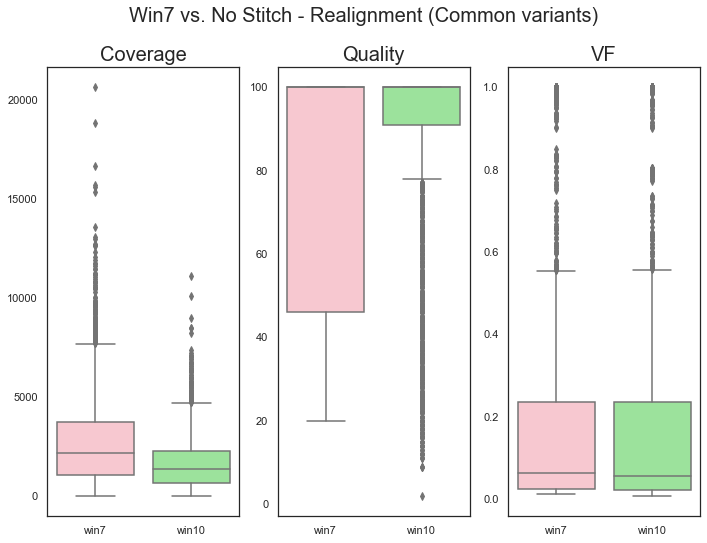

In [44]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
plt.suptitle('Win7 vs. No Stitch - Realignment (Common variants)', fontsize=20)

DataForPlot = common_variants_win7_NoStitch_Real

plt.subplot(1,3,1)
my_pal = {"Coverage": "pink", "10Coverage": "lightgreen"}
ax = sns.boxplot(data=DataForPlot[["Coverage","10Coverage"]],palette=my_pal)
ax.set_xticklabels(["win7","win10"])
ax.set_title("Coverage",size=20)


plt.subplot(1,3,2)
my_pal = {"QUAL": "pink", "10QUAL": "lightgreen"}
ax = sns.boxplot(data=DataForPlot[["QUAL","10QUAL"]], palette=my_pal)
ax.set_xticklabels(["win7","win10"])
ax.set_title("Quality",size=20)

plt.subplot(1,3,3)
my_pal = {"VF": "pink", "10VF": "lightgreen"}
ax = sns.boxplot(data=DataForPlot[["VF","10VF"]], palette=my_pal)
ax.set_xticklabels(["win7","win10"])
ax.set_title("VF",size=20)

hide_toggle()

<a class="anchor" id="4.2.1"></a>

### Common variants (Differences)

In [45]:
#print("Coverage differences between win7 and No Stitch - Realignment common variants")
common_variants_win7_NoStitch_Real["Coverage-diff"] = common_variants_win7_NoStitch_Real["Coverage"] - common_variants_win7_NoStitch_Real["10Coverage"]
#display(common_variants_win7_NoStitch_Real.head(1))
hide_toggle()

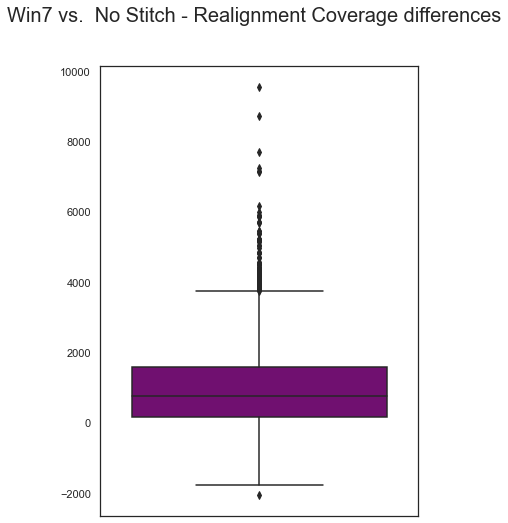

In [46]:
sns.set(rc={'figure.figsize':(5.7,8.27)})
sns.set_style("white")
plt.suptitle('Win7 vs.  No Stitch - Realignment Coverage differences', fontsize=20)

my_pal = {0: "purple"} # I dont know why this is called 0
ax = sns.boxplot(data=common_variants_win7_NoStitch_Real["Coverage-diff"],palette=my_pal)
ax.set_xticklabels([""])
hide_toggle()

# How many and how are the variants called by win7 and not called by win10 and vice versa.
 <a class="anchor" id="5"></a>



It is critical to analyse the variants that are not called in the win10 version but they were called with the previous version in order to see if we miss mutations with clinical significance in our new update.

In other words, we need to analyse the part of the red circle no cover for the green circle in the next plot.

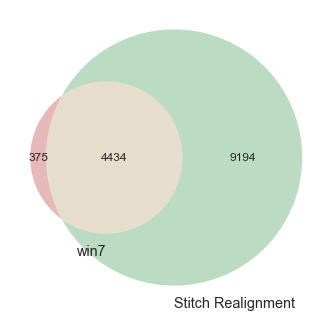

In [46]:
v = venn2([set(win7['Sample_ID'].to_list()), 
       set(Stitch_Realm['10Sample_ID'].to_list()),
      ],
       set_labels=('win7', 'Stitch Realignment', )
     )

Seeing the similarity between the 4 win10 versions, it is not relatively necessary to make the following comparison of these 4 against win7. Therefore, to carry out the following analysis, I will use only the version *Stitch - Realinment* because it is the version that has shown the highest number of different variants.

In [47]:
common_variants_win7_win10 = set(win7["Sample_ID"]) & set (Stitch_Realm["10Sample_ID"])
len(common_variants_win7_win10)

4434

4434 variants uncommon variants found.

I will use the *common_variants_win7_win10* set to take the 375 variants called by win7 and not by win10

In [48]:
only_win7_called = win7[~win7["Sample_ID"].isin(common_variants_win7_win10)]
print(only_win7_called['VF'].mean())
print(only_win7_called['QUAL'].mean())
print(only_win7_called.groupby('FILTER').count())

0.1389579746945483
45.776
        Indicator  Sample_ID  QUAL   GT   AD   SB  Coverage   VF
FILTER                                                          
LowDP          30         30    30   30   30   30        30   30
PASS          166        166   166  166  166  166       166  166
R8              4          4     4    4    4    4         4    4
SB            174        174   174  174  174  174       174  174
SB;R8           1          1     1    1    1    1         1    1


The mean of the frequencies and quality of these 375 variants is 0.13 and 45.7 respectively. The 44% (166 out of 375) of these variants pass all filter. Therefore from a quality point of view , they could have an impact on the patient. It would be advisable to provide these variants to the professional who is in charge of interpreting these variants to ensure that the new pipeline (the one that we will continue to use in our laboratory) not rules out important variants.

# No Stitch - Realignment vs. Stitch - Realignment <a class="anchor" id="6"></a>
(This is going to be called No Stitch vs. Stitch)

In [53]:
# Firts, let´s delete the previous indicator
NoStitch_Real = Stitch_Real.drop('Indicator', 1)
Stitch_Real = Stitch_Real.drop('Indicator', 1)

NoStitch_Real.insert(0, 'Indicator', 'No Stitch')
Stitch_Real.insert(0, 'Indicator', 'Stitch')
frames = [NoStitch_Real, Stitch_Real]
NoStitch_Stitch = pd.concat(frames)
print("No Stitch and Stitch data with indicators")
display(NoStitch_Stitch)
hide_toggle()

No Stitch and Stitch data with indicators


/var/folders/f6/m9w6j22j51b43p3xhgm6gw0m0000gn/T/ipykernel_40817/1812557754.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  NoStitch_Real = Stitch_Real.drop('Indicator', 1)
/var/folders/f6/m9w6j22j51b43p3xhgm6gw0m0000gn/T/ipykernel_40817/1812557754.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  Stitch_Real = Stitch_Real.drop('Indicator', 1)


,Indicator,Sample_ID,QUAL,FILTER,GT,AD,SB,Coverage,VF,Wnumber,position
0,No Stitch,W2114579_S4.bamchr1:36932358T>C,12,q20,0/1,"1263,13",-13.9406,1276,0.010188,W2114579,chr1:36932358T>C
1,No Stitch,W2114579_S4.bamchr1:36932529T>C,10,LowVariantFreq;q20,0/1,"1250,12",-13.3770,1262,0.009509,W2114579,chr1:36932529T>C
2,No Stitch,W2114579_S4.bamchr1:36932888A>G,10,LowVariantFreq;q20,0/1,"1117,11",-11.4635,1128,0.009752,W2114579,chr1:36932888A>G
3,No Stitch,W2114579_S4.bamchr1:36933405GC>G,27,PASS,0/1,"1383,14",-13.3591,1397,0.010021,W2114579,chr1:36933405GC>G
4,No Stitch,W2114579_S4.bamchr1:36933574T>G,33,SB,0/1,"663,10",-0.4444,673,0.014859,W2114579,chr1:36933574T>G
...,...,...,...,...,...,...,...,...,...,...,...
13623,Stitch,W2114560_S6.bamchrX:133547816A>AT,78,R3x6,0/1,"1216,22",-42.2221,1238,0.017771,W2114560,chrX:133547816A>AT
13624,Stitch,W2114560_S6.bamchrX:133547816AT>A,100,R3x6,0/1,"1206,35",-88.2748,1241,0.028203,W2114560,chrX:133547816AT>A
13625,Stitch,W2114560_S6.bamchrX:133548026GT>G,34,R3x6,0/1,"1472,16",-19.2723,1488,0.010753,W2114560,chrX:133548026GT>G
13626,Stitch,W2114560_S6.bamchrX:133559255A>G,13,q20,0/1,"1213,13",-14.0903,1226,0.010604,W2114560,chrX:133559255A>G


<Figure size 4560x6616 with 0 Axes>

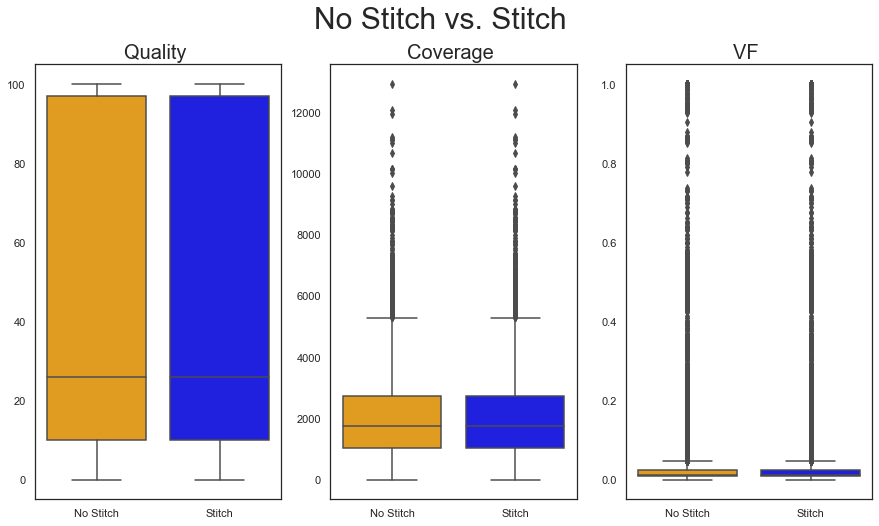

In [54]:
sns.set_style("white")
plt.figure(dpi=800)
plt.figure(figsize = (15,8))
my_pal = {"No Stitch": "Orange", "Stitch": "blue"}

plt.suptitle('No Stitch vs. Stitch', fontsize=30)

DataForPlot = NoStitch_Stitch

plt.subplot(1,3,1)
ax=sns.boxplot(x=DataForPlot["Indicator"], y=DataForPlot["QUAL"], palette=my_pal )
ax.set_title('Quality ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')

plt.subplot(1,3,2)
ax=sns.boxplot(x=DataForPlot["Indicator"], y=DataForPlot["Coverage"], palette=my_pal)
ax.set_title('Coverage ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')

plt.subplot(1,3,3)
ax=sns.boxplot(x=DataForPlot["Indicator"], y=DataForPlot["VF"], palette=my_pal)
ax.set_title('VF ',size=20)
ax.set_ylabel('')
ax.set_xlabel('')

hide_toggle()

 
# Sensitivity and Specificity analysis <a class="anchor" id="7"></a>

Finally, I am going to analysis the sensitivity and specifity of the variants called of the four win10 outputs considerig the variants called in the win7 as the reality.  

How this analysis is designed:

To evaluate the prediction of our four win10 datasets, these need to be compare with the win7 data (control). We assume that the win7-variants that passed all filters and had a quality equal to 100 are the real positive cases. The rest variants are real negative cases. To be able to do this comparison, we have only considered the common variants between the 5 outputs.

In this context, we can classify the win10 variants in the following way:


### Step 1. For each win10 output, create a comparative data frame to see how many win10 variants match with the win7 variants

An ilustrative table with the four possibles cases:

| ALL-Common Variants || CONTROL (win7-PASS-100QUAL-variants)  | Stitch - Realignment (win10-PASS-100QUAL-variants)  |  Classification |  |  |
|---||---|---|---|---|---|
|Ch1:1234567C>T || Ch1:1234567C>T | Found | True-positive |  |  |
|Ch2:987654321G>AAAAT|| Ch2:987654321G>AAAAT | No found | False-negative |  |  |
|Ch3:246810G>GGGGA|| Real negative | Found | False-positive |  |  |
|ChX:246810G>TTGGA|| Real negative| No Found | True-negative |  |  |


~~~     
    - 1 column: Variants in common with all outputs.
    - 2 column: Win7 variants that pass all filters and the QUAL=100 are Real-positives.
        Variants that do not meet these conditions are Real-negatives.
    - 3 column: The variants of this column that are found in the previous column are  True-positive.
        The variants in this column that doesnt match with the previous column are False-positive. 
        Variants that don´t match with the second columns are False-negative.
        Finally, variants in the first column that are neither in the second nor in the third are True-negative
~~~

### Step 2. Calculate the confusion matrix
After this, we can create a confusion matrix. Followingh the last example, the confusion matrix would be:

| Actual class/Predicted class | PASS-100QUAL-win10 |NO  PASS-100QUAL-win10  |
|---|---|---|
| PASS-100QUAL-win7  | TP = 1 | FP = 1 |
| NO  PASS-100QUAL-win7   |FN = 1  | TN = 1  |


 ### Step 3. Calculate sensitivity
 With the data of the confusion matrix we can calculate the sensitivity:
 
 

\begin{gather*}
Sensitivity = \frac{\text{number true positives}}{\text{number of true positives} + \text{number of false negatives}} 
\end{gather*}

 ### Step 4. Calculate specificity

And the specificity:

\begin{gather*}
Specificity = \frac{\text{number true negatives}}{\text{number of true negatives} + \text{number of false positives}} 
\end{gather*}


 ###  Step 5. ROC curve
 
Having the sensitivity and specificity we can plot a ROC curve to evaluate and see if there are signbifically differences between the four tests.

Next image is a ilustrative plot of a ROC space and plots of four prediction examples taken from [wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).


![title](./roc_curve_wikipedia.png)



So first, take ALL common variants in the 5 datasets (the total cases in this study).

In [64]:
all_common_variant_ID_list = set(win7["Sample_ID"]) & set (Stitch_Realm["10Sample_ID"]) & set (NoStitch_NoRealm["10Sample_ID"]) & set (NoStitch_Realm["10Sample_ID"]) & set (Stitch_NoRealm["10Sample_ID"]) 
# We save them in a data frame
comparison = pd.DataFrame(list(all_common_variant_ID_list), columns=['All_common_variants_ID'])
len(comparison)


4433

4433 variants are in common between the 5 outputs.

With this common-variants list, for each output we can :

    1) take the common variants. 

    2) (a second filter) take the ones that FILTER = PASS and  QUAL = 100.

In [69]:
def take_common_PASS_100QUAL_variants(datasets):
    """
    First, the list all_common_variant_ID_list is used to select the common variants.
    Second, from these common variants, take the ones that FILTER = PASS and QUAL = 100.
    """
    all_common_v_win7 = datasets[datasets["10Sample_ID"].isin(all_common_variant_ID_list)]
    output = all_common_v_win7.loc[(all_common_v_win7['10FILTER']=="PASS") & (all_common_v_win7['10QUAL']== 100)]
    return output
# For win7    
#control = take_common_PASS_100QUAL_variants(win7)
control.head(2)

,Indicator,Sample_ID,QUAL,FILTER,GT,AD,SB,Coverage,VF
4,win7,W2114579chr2:25463483G>A,100.0,PASS,0/1,"1679,1585",-100.0,3264,0.485600
6,win7,W2114579chr2:25466888G>T,100.0,PASS,1/1,"3,3114",-100.0,3117,0.999038


We need to do the same for the win10 outputs

In [74]:
# For No Stitch - Realignment
test_NoStitch_Realm = take_common_PASS_100QUAL_variants(NoStitch_Realm)

# For Stitch - Realignment
test_Stitch_Realm = take_common_PASS_100QUAL_variants(Stitch_Realm)

# For Stitch - No Realignment
test_NoStitch_NoRealm = take_common_PASS_100QUAL_variants(Stitch_NoRealm)

# For No Stitch - No Realignment
test_Stitch_NoRealm = take_common_PASS_100QUAL_variants(Stitch_NoRealm)

We can start creating now the comparative table. First thing is to merge all common variants with the win7 outputs.

In [75]:
comparative = comparison.merge(control[['Sample_ID']],left_on='All_common_variants_ID',right_on='Sample_ID',how='outer').fillna('Real negative')
comparative = comparative.rename(columns={'Sample_ID': 'CONTROL(win7-PASS-100QUAL-variants)'})
comparative

,All_common_variants_ID,CONTROL(win7-PASS-100QUAL-variants)
0,W2114280chr8:117868531TA>T,Real negative
1,W2112426chr8:117868531TAAA>T,Real negative
2,W2114579chr11:534409GCCCAGC>G,W2114579chr11:534409GCCCAGC>G
3,W2112623chr17:7579651CCTCCAGGT>C,W2112623chr17:7579651CCTCCAGGT>C
4,W2114486chr7:148508833A>G,W2114486chr7:148508833A>G
...,...,...
4428,W2114560chr11:534403GCCCAGGCCCAGC>G,W2114560chr11:534403GCCCAGGCCCAGC>G
4429,W2114560chr4:106154990T>TATAG,W2114560chr4:106154990T>TATAG
4430,W2114249chrX:129159221TGAG>T,Real negative
4431,W2114514chr7:101813724A>C,Real negative


And now, we add a new column per win10 output mergen these new variants with the win7-variants.

In [76]:
def compare_control_test(test,column_name):
    """
    input: A test data frame (PASS-100QUAL variants)
    Output: Add a new column in the comparative table with the number of TP, TN, FP and FN cases.
    """
    # Build variables to np.select
    condlist = [comparative['CONTROL(win7-PASS-100QUAL-variants)'].isin(test['10Sample_ID']),
                ~comparative['CONTROL(win7-PASS-100QUAL-variants)'].isin(test['10Sample_ID'])
                    & comparative['CONTROL(win7-PASS-100QUAL-variants)'].ne('Real negative'),
                comparative['All_common_variants_ID'].isin(test['10Sample_ID'])
                    & comparative['CONTROL(win7-PASS-100QUAL-variants)'].eq('Real negative')]

    choicelist = ['True-positive', 'False-negative', 'False-positive']

    default = 'True-negative'

    # Create new column
    comparative[column_name] = np.select(condlist, choicelist, default)
    return comparative

comparative = compare_control_test(test_NoStitch_Realm,"NoStitch_Real")
comparative = compare_control_test(test_Stitch_Realm,"Stitch_Real")
comparative = compare_control_test(test_NoStitch_NoRealm,"NoStitch_NoReal")
comparative = compare_control_test(test_Stitch_NoRealm,"Stitch_NoReal")

This is the comparative table:

In [77]:
comparative

,All_common_variants_ID,CONTROL(win7-PASS-100QUAL-variants),NoStitch_Real,Stitch_Real,NoStitch_NoReal,Stitch_NoReal
0,W2114280chr8:117868531TA>T,Real negative,True-negative,True-negative,True-negative,True-negative
1,W2112426chr8:117868531TAAA>T,Real negative,True-negative,True-negative,True-negative,True-negative
2,W2114579chr11:534409GCCCAGC>G,W2114579chr11:534409GCCCAGC>G,True-positive,True-positive,True-positive,True-positive
3,W2112623chr17:7579651CCTCCAGGT>C,W2112623chr17:7579651CCTCCAGGT>C,True-positive,True-positive,True-positive,True-positive
4,W2114486chr7:148508833A>G,W2114486chr7:148508833A>G,True-positive,True-positive,True-positive,True-positive
...,...,...,...,...,...,...
4428,W2114560chr11:534403GCCCAGGCCCAGC>G,W2114560chr11:534403GCCCAGGCCCAGC>G,True-positive,True-positive,True-positive,True-positive
4429,W2114560chr4:106154990T>TATAG,W2114560chr4:106154990T>TATAG,True-positive,True-positive,True-positive,True-positive
4430,W2114249chrX:129159221TGAG>T,Real negative,False-positive,False-positive,False-positive,False-positive
4431,W2114514chr7:101813724A>C,Real negative,True-negative,True-negative,True-negative,True-negative


From the comparative table, we can count the number of TP,TN,FP and FN

In [78]:
comparative["NoStitch_Real"].value_counts()
comparative["Stitch_Real"].value_counts()
comparative["NoStitch_NoReal"].value_counts()
comparative["Stitch_NoReal"].value_counts()

True-negative     2682
True-positive     1078
False-negative     386
False-positive     287
Name: Stitch_NoReal, dtype: int64

## The confusion matrix for the four tests


| Actual class/Predicted class | + NoStitch_Real | - NoStitch_Real | + Stitch_Real | - Stitch_Real | + NoStitch_NoReal | - NoStitch_NoReal | + Stitch_NoReal | - Stitch_NoReal |
|---|---|---|---|---|---|---|---|---|
| PASS-100QUAL-win7 | 1077 | 387 | 1075 | 389 | 1083 | 381 | 1078 | 386 |
| NO  PASS-100QUAL-win7 | 276 | 2693 | 286 |2683   | 293 | 2676  | 293 | 2682  |

## Calculation of sensitivity and specificity

In [79]:
def cal_sensitivity(test):
    return comparative[test].value_counts().get("True-positive")/(comparative[test].value_counts().get("True-positive") + comparative[test].value_counts().get("False-negative"))

def cal_specificity(test):
    return comparative[test].value_counts().get("True-negative")/(comparative[test].value_counts().get("True-negative") + comparative[test].value_counts().get("False-positive")) 

## The sensitive and specificity results:

### Stitch No Realignment test:

In [80]:
print(" - Sensitivity: ", cal_sensitivity("Stitch_NoReal"))

 - Sensitivity:  0.7363387978142076


In [81]:
print(" - Specificity: ", cal_specificity("Stitch_NoReal"))

 - Specificity:  0.9033344560458066


### Stitch Realignment test:

In [82]:
print(" - Sensitivity: ", cal_sensitivity("Stitch_Real"))

 - Sensitivity:  0.7342896174863388


In [83]:
print(" - Specificity: ", cal_specificity("Stitch_Real"))

 - Specificity:  0.9036712697878073


### No Stitch  Realignment test:

In [84]:
print(" - Sensitivity: ", cal_sensitivity("NoStitch_Real"))

 - Sensitivity:  0.735655737704918


In [85]:
print(" - Specificity: ", cal_specificity("NoStitch_Real"))

 - Specificity:  0.9070394072078141


### No Stitch No Realignment test:

In [86]:
print(" - Sensitivity: ", cal_sensitivity("NoStitch_NoReal"))

 - Sensitivity:  0.7363387978142076


In [87]:
print(" - Specificity: ", cal_specificity("NoStitch_NoReal"))

 - Specificity:  0.9033344560458066


## Creation of ROC curve

In [88]:
# Same data for the oblique line in the ROC curve.

data = {'X':[0,0.5,1],
        'Y':[0,0.5,1]}
 
# Create DataFrame
roc = pd.DataFrame(data)

The code for the ROC curve plot with results of our tests.

Text(0.1, 0.5, 'The four test are there')

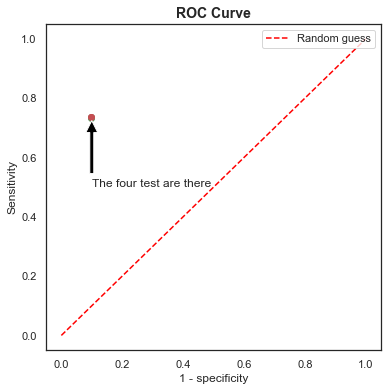

In [89]:
fig = plt.figure(figsize = (6,6))
plt.suptitle('', fontsize=20)

ax = fig.add_subplot(111)
ax.set_title("ROC Curve",fontsize=14,fontweight="bold")

ax.set_xlabel("1 - specificity")
ax.set_ylabel("Sensitivity")

sns.set_style("white")
# Random guess line
ax = sns.lineplot(x="X", y="Y", data=roc,color="red",label="Random guess")
ax.lines[0].set_linestyle("--")
ax.legend(loc="upper right")


ax.plot([1-cal_specificity("Stitch_NoReal") ],[cal_sensitivity("Stitch_NoReal")],"o")
ax.plot([1-cal_specificity("NoStitch_NoReal") ],[cal_sensitivity("NoStitch_NoReal")],"o")
ax.plot([1-cal_specificity("Stitch_Real") ],[cal_sensitivity("Stitch_Real")],"o")
ax.plot([1-cal_specificity("NoStitch_NoReal") ],[cal_sensitivity("NoStitch_NoReal")],"o")
ax.annotate("The four test are there",xy=(0.1,0.735),xytext=(0.1,0.5),arrowprops=dict(facecolor="black",shrink=0.05))
# https://matplotlib.org/2.0.2/users/text_intro.html

## Additional comments:



   - 1) With the sensitivity and specificity we can measure the validity of a test, this is its ability to distinguish between individuals with and without a particular condition. However, if we want to know how many times more or less likely patients with a disease are to have a particular result than patients without the disease, we need to apply the Likelihood ratios. There is one for positive results and its equivalent for negative results.
   
   
\begin{gather*}
LR + = \frac{\text{sensitivity}}{\text{1} - \text{specificity}} 
\end{gather*}

    And its equivalent for negatives results

\begin{gather*}
LR - = \frac{\text{1 - sensitivity}}{\text{specificity}} 
\end{gather*}

I havent used it in this analysis but I have wanted to mention them. 

  - 2) Apart from numpy (used in this notebook) I am aware of other statistical statistics packages such as  Scipy.Stats and Statsmodel. However, instead of carrying out the test in one line of code and getting the results,  for this statistical analysis I have preferred to develop step by step the code while explaining what I have done.
 

~~~
                                                                                                                                                               Manuel Domínguez

~~~